# Name, Student id

Kristian Tveiten: 509264, Abdulfatah Abdi-Salah, Torkjell Romskaug: 488082

Group name: Group 13

Kaggle name: Group 13

## Tools

In [6]:
# mean earth radius - https://en.wikipedia.org/wiki/Earth_radius#Mean_radius
_AVG_EARTH_RADIUS_KM = 6371.0088

# Unit values taken from http://www.unitconversion.org/unit_converter/length.html
_CONVERSION_TO_KILOMETERS = 1.0
_CONVERSION_TO_METERS = 1000.0
_CONVERSION_TO_MILES = 0.621371192
_CONVERSION_TO_NAUTICAL_MILES = 0.539956803
_CONVERSION_TO_FEETS = 3280.839895013
_CONVERSION_TO_INCHES = 39370.078740158

def _get_avg_earth_radius(unit):
	if unit == 'km':
		return _AVG_EARTH_RADIUS_KM
	elif unit == 'm':
		return _AVG_EARTH_RADIUS_KM * _CONVERSION_TO_METERS
	elif unit == 'mile':
		return _AVG_EARTH_RADIUS_KM * _CONVERSION_TO_MILES
	elif unit == 'nmile':
		return _AVG_EARTH_RADIUS_KM * _CONVERSION_TO_NAUTICAL_MILES
	elif unit == 'feet':
		return _AVG_EARTH_RADIUS_KM * _CONVERSION_TO_FEETS
	elif unit == 'inch':
		return _AVG_EARTH_RADIUS_KM * _CONVERSION_TO_INCHES
	else:
		raise ValueError('unit should be "km", "m", "mile", "nmile", "feet" or "inch". Found {0}.'.format(unit))

def haversine(points1, points2=(55.754093, 37.620407), unit='km'):
	avg_earth_radius = _get_avg_earth_radius(unit)

	points2 = np.radians(points2)

	lat1, lon1 = np.radians(points1[0]), np.radians(points1[1])
	lat2, lon2 = points2[0], points2[1]

	lat_diff = lat1 - lat2
	lon_diff = lon1 - lon2

	d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff * 0.5) ** 2

	return 2 * avg_earth_radius * np.arcsin(np.sqrt(d))

# EDA

### import data

In [1]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, KFold, cross_val_score, StratifiedKFold, GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_log_error
from DataCleaning import *
from FeatureEng import *
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import seaborn as sns
from sklearn.feature_selection import RFECV
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
train_apt = pd.read_csv("data/apartments_train.csv")
test_apt = pd.read_csv("data/apartments_test.csv")
train_buil = pd.read_csv("data/buildings_train.csv")
test_buil = pd.read_csv("data/buildings_test.csv")

train_merged = pd.merge(train_apt, train_buil.set_index('id'), how="left", left_on='building_id', right_index=True)
test_merged = pd.merge(test_apt, test_buil.set_index('id'), how="left", left_on='building_id', right_index=True)

## Domain knowledge
In order to understand price fluctuations not explainable by the supplied dataset alone, we decided to look
for additional data to extract features from.

### Metro Stations
By looking at Moscows metro infrastructure and doing further research, we proposed that the metro must be an important
factor for the people living there. We found a source for datasets in Moscow: https://data.mos.ru/.

From this source we obtained a dataset for every entrance to metro vestibules in Moscow (including geographical data) from:
https://data.mos.ru/opendata/7704786030-entrances-to-vestibules-in-moscow-subway-stations

In order to obtain this dataset, we had to make an API call to the API (using an API key) then save the dataset response.
We then used a haversine function (defined in the Tools section) in order to efficiently obtain the distance from every building to
every entrance in the metro dataset, and then selecting the smallest value as the closest metro to the corresponding building.

Using this distance to metro feature improved our score significantly.

In [4]:
def metro_dist(data):
    geojson = pd.read_json('data/response.json')
    metros = pd.json_normalize(geojson["features"])
    metros = metros.drop(columns=["type","geometry.type","properties.DatasetId"])
    metros = metros.rename(columns={"geometry.coordinates": "loc", "properties.Attributes.global_id" : "id"})
    metros = metros[['id','loc']]
    metros[["lat", "long"]] = pd.DataFrame(metros["loc"].tolist(), columns=["lat", "long"])
    metros = metros.drop(columns="loc")

    dist = None
    for idx in data.building_id:
        dist = haversine([metros.lat.values,metros.long.values], [data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()],unit="m")
        data.loc[data.building_id == idx, "dist_metro"] = dist.min()

    return data


In [25]:
train_merged = metro_dist(train_merged)
train_merged.dist_metro.describe()
plt.scatter(train_merged.dist_metro, train_merged.price)

We tried to use the Google Maps API for calculating the exact walking distance, but it resulted in alot of NaN values,
0 and unnaturally high values. It did not perform better than the simple euclidean distance

```python
API_key = ''#enter Google Maps API key
gmaps = googlemaps.Client(key=API_key)

#Add the list of coordinates to the main data set
destinations = list(zip(metros.lat,metros.long))
dist = None
test = pd.DataFrame(columns=["id","lat","long"])
for idx in data.id:
    origin = list(zip(data.loc[data.id == idx, "longitude"], data.loc[data.id == idx, "latitude"]))
    closest_metro = metros.iloc[Tools.closest_node(origin,destinations)].values
    test = test.append({'id':idx,'lat':closest_metro[0],'long':closest_metro[1]}, ignore_index=True)
    # GMaps
i = 0
for t in test.id:
    origin = list(zip(test.loc[test.id == t,"lat"],test.loc[test.id == t,"long"]))
    destination = list(zip(data.loc[data.id == t, "longitude"], data.loc[data.id == t, "latitude"]))

    result = float("NaN")
    try:
        result = gmaps.distance_matrix(origin, destination, mode='walking')["rows"][0]["elements"][0]["distance"]["value"]
    except KeyError as e:
        pass
    data.loc[data.id==t, "walk_metro"] = result
```

### Universities
As students ourselves, we know how prices can be quite different for what you get if you live close to a
popular university or far away from it. Therefore, we decided to look further into this.
As there were alot of universities in Moscow, we decided to look into the 15 most popular universities.
The top 15 was manually derived from online rankings, and then coordinates obtained from Google Maps.
Which university was closest was also added in for a better overall score.

In [2]:
def university_dist(data):
    universities = [
        (55.67249540277297, 37.57367075739323),
        (55.848593408183014, 37.63366154242958),
        (55.6927502611028, 37.39749771164194),
        (55.85989907696161, 37.47471830960826),
        (55.71275216609847, 37.39960668456914),
        (55.668081662254856, 37.50617732696646),
        (55.73388744190375, 37.43235888837524),
        (55.67545847268359, 37.57650405765294),
        (55.76998506895896, 37.71307631112898),
        (55.636381586267106, 37.61111962636034),
        (55.78362014503218, 37.660868227044766),
        (55.69875568681356, 37.39433724232817),
        (55.82769889412336, 37.46133846385291),
        (55.8716119484216, 37.31466813820559),
        (55.77763401914524, 37.43414293198491)
    ]
    uni = pd.DataFrame(universities)

    dist = None
    for idx in data.building_id.unique():
        origin = list(zip(data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()))
        destinations = list(zip(uni[1], uni[0]))
        dist = haversine([uni[1].values, uni[0].values], [data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()], unit="m")
        data.loc[data.building_id == idx, "dist_uni"] = dist.min()
        data.loc[data.building_id == idx, "uni"] = Tools.closest_node(origin, destinations)

    return data


In [7]:

train_merged = university_dist(train_merged)
train_merged.dist_uni.describe()
plt.scatter(train_merged.dist_uni, train_merged.price)
plt.title("Distance to nearest university by price")
plt.show()
plt.scatter(train_merged.uni, train_merged.price)
plt.title("Closesness to which university by price")
plt.show()

### Park Distance
Another important factor for most families, dog owners and others is the distance to the closest park.
We obtained a dataset for the parks in Moscow, and extracted the distances from every building to the
closest park. This feature did not perform well, most likely due to the coordinate for the park being in
the center. This would most likely perform better if we could have obtained data of where the perimeter of the
parks is instead as many parks can be quite large.

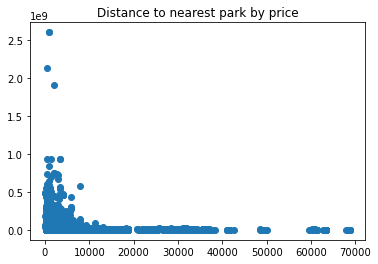

In [27]:
def parks_dist(data):
    """
    Reads a list of park coordiantes, and calculates each appartments distance so the closest park.
    """
    parks = pd.read_xml("data/parks.kml")

    # drop irrelevant columns
    parks.drop(["description","Snippet","name"], axis=1, inplace=True)
    # remove extra ",0" at the end of the rows
    parks.coordinates = parks.coordinates.str[:-2]

    # split into lat and long
    new = parks["coordinates"].str.split(",", n=1,expand=True)
    parks["lat"] = new[1]
    parks["long"] = new[0]

    # cast to float
    parks.lat = parks.lat.astype(float)
    parks.long = parks.long.astype(float)

    # drop the old coordinates
    parks.drop("coordinates", axis=1, inplace=True)

    # calculate the distances
    dist = None
    for idx in data.building_id.unique():
        #print([data.loc[data.id == idx, "longitude"],data.loc[data.id == idx, "latitude"]])
        dist = haversine([parks.long.values, parks.lat.values], [data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()], unit="m")
        data.loc[data.building_id == idx, "dist_parks"] = dist.min()
    return data

train_merged = parks_dist(train_merged)
train_merged.dist_parks.describe()
plt.scatter(train_merged.dist_parks, train_merged.price)
plt.title("Distance to nearest park by price")
plt.show()

### Distance to nearest transport hub
Transport hubs is the central hubs where multiple forms and lines of transportation intersect, meaning that
settlements close to these would not need to travel into the hub to change to another metro for example.
This feature seemed to correlate too much with district as the hubs were quite central, and it did not lead
to better performance sadly.

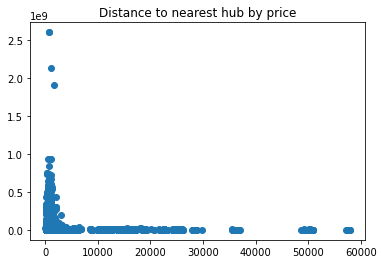

In [28]:
def hub_dist(data):
    geojson = pd.read_json('data/transporthubs.json')
    hubs = pd.json_normalize(geojson["features"])
    hubs = hubs[["geometry.coordinates", "properties.Attributes.ID_en"]]
    hubs = hubs.rename(columns={"geometry.coordinates": "loc", "properties.Attributes.ID_en": "id"})
    hubs[["lat", "long"]] = pd.DataFrame(hubs["loc"].tolist(), columns=["lat", "long"])
    hubs = hubs.drop(columns="loc")

    dist = None
    for idx in data.building_id.unique():
        # print([data.loc[data.id == idx, "longitude"],data.loc[data.id == idx, "latitude"]])
        dist = haversine([hubs.lat.values, hubs.long.values],
                               [data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()], unit="m")
        data.loc[data.building_id == idx, "dist_hub"] = dist.min()

    return data

train_merged = hub_dist(train_merged)
train_merged.dist_hub.describe()
plt.scatter(train_merged.dist_hub, train_merged.price)
plt.title("Distance to nearest hub by price")
plt.show()

### Distance to nearest train station
We then looked at the distance to nearest train stations.
This resulted in worse performance
https://data.mos.ru/opendata/7704786030-train-stations

In [8]:
def train_station_dist(data):
    geojson = pd.read_json('data/trainstations.json')
    train_stations = pd.json_normalize(geojson["Cells"])
    train_stations = train_stations[["geoData.coordinates", "global_id"]]
    train_stations = train_stations.rename(columns={"geoData.coordinates": "loc", "global_id": "id"})
    train_stations[["lat", "long"]] = pd.DataFrame(train_stations["loc"].tolist(), columns=["lat", "long"])
    train_stations = train_stations.drop(columns="loc")

    dist = None
    for idx in data.building_id.unique():
        # print([data.loc[data.id == idx, "longitude"],data.loc[data.id == idx, "latitude"]])
        dist = haversine([train_stations.lat.values, train_stations.long.values],
                               [data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()], unit="m")
        data.loc[data.building_id == idx, "dist_train_station"] = dist.min()

    return data

train_merged = train_station_dist(train_merged)
train_merged.dist_train_station.describe()
plt.scatter(train_merged.dist_train_station, train_merged.price)
plt.title("Distance to nearest train station by price")
plt.show()

### Distance to nearest gym
Gyms are important to alot of people, so we decided to checkout how distance to closest gym could affec the price.
This did unfortunately perform well.

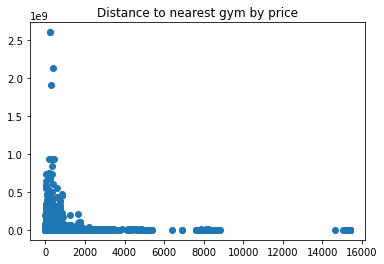

In [9]:
def gym_dist(data):
    geojson = pd.read_json('data/gyms.json')
    gyms = pd.json_normalize(geojson["features"])
    gyms = gyms[["geometry.coordinates", "properties.Attributes.global_id"]]
    gyms = gyms.rename(columns={"geometry.coordinates": "loc", "properties.Attributes.global_id": "id"})
    gyms[["lat", "long"]] = pd.DataFrame(gyms["loc"].tolist(), columns=["lat", "long"])
    gyms = gyms.drop(columns="loc")

    dist = None
    for idx in data.building_id.unique():
        # print([data.loc[data.id == idx, "longitude"],data.loc[data.id == idx, "latitude"]])
        dist = haversine([gyms.lat.values, gyms.long.values],
                               [data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()], unit="m")
        data.loc[data.building_id == idx, "dist_gym"] = dist.min()

    return data

train_merged = gym_dist(train_merged)
train_merged.dist_gym.describe()
plt.scatter(train_merged.dist_gym, train_merged.price)
plt.title("Distance to nearest gym by price")
plt.show()

### Distance to stadiums and water facilities
We looked at the distance to stadiums in Moscow and water facilities, but they did not correlate well with the price

In [ ]:
def stadium_dist(data):
    stadiums = [
        (55.791389, 37.559722),
        (55.803611, 37.741111),
        (55.791389, 37.516111),
        (55.817861, 37.44025),
        (55.715556, 37.553611),
    ]
    uni = pd.DataFrame(stadiums)

    dist = None
    for idx in data.id:
        dist = haversine([uni[1].values,uni[0].values], [data.loc[data.id == idx, "longitude"], data.loc[data.id == idx, "latitude"]],unit="km")
        data.loc[data.id == idx, "dist_stadiums"] = dist.min()

    return data

def water_facilites(data):
    water_facilites = [
        (55.661634674466995, 37.700948709661304),
        (55.686441683977975, 37.94336506164841),
    ]
    uni = pd.DataFrame(water_facilites)

    dist = None
    for idx in data.id:
        dist = haversine([uni[1].values,uni[0].values], [data.loc[data.id == idx, "longitude"], data.loc[data.id == idx, "latitude"]],unit="km")
        data.loc[data.id == idx, "dist_water_treatment"] = dist.min()

    return data

### Distance to closest surface transport stop
https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops
We figured that the distance to the closest public transport stop on the surface is important to a small degree
when buying apartments in certain areas. This feature did not make the model perform better

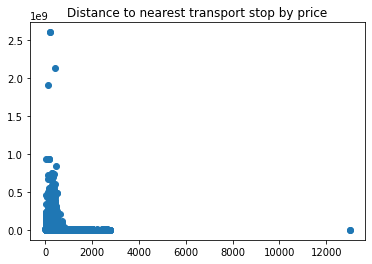

In [10]:
def closest_transport_stop(data):
    geojson = pd.read_json('data/surfacetransportstops.json')
    stops = pd.json_normalize(geojson["Cells"])
    stops = stops[["Latitude_WGS84_en", "Longitude_WGS84_en", "global_id"]]
    stops = stops.rename(columns={"Latitude_WGS84_en": "lat", "Longitude_WGS84_en": "long", "global_id": "id"})
    stops.lat = stops.lat.astype(float, errors="raise")
    stops.long = stops.long.astype(float, errors="raise")

    dist = None
    for idx in data.building_id.unique():
        # print([data.loc[data.id == idx, "longitude"],data.loc[data.id == idx, "latitude"]])
        dist = Tools.haversine([stops.long.values, stops.lat.values],
                               [data.loc[data.building_id == idx, "longitude"].unique(),
                                data.loc[data.building_id == idx, "latitude"].unique()], unit="m")
        data.loc[data.building_id == idx, "dist_stop"] = dist.min()

    return data

train_merged = closest_transport_stop(train_merged)
train_merged.dist_stop.describe()
plt.scatter(train_merged.dist_stop, train_merged.price)
plt.title("Distance to nearest transport stop by price")
plt.show()


## Intuitive

In [11]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc

print(f'Loaded {len(train_apt)} apartments')
with open('data/apartments_meta.json') as f:
    apartments_meta = json.load(f)

describe_data(train_apt, apartments_meta)

print(f'Loaded {len(train_buil)} buildings')
with open('data/buildings_meta.json') as f:
    buildings_meta = json.load(f)
train_buil.head()

describe_data(train_buil, buildings_meta)

Loaded 23285 apartments
Loaded 6791 buildings


We noticed that the apartment data had a lot of missing features, like layout (ca 75%), ceiling (ca 50%), balconies & loggias (45 %).
Building data also had quite a few features with lots of missing data that will be subject to data cleaning later.

### Checking correlation of features
By plotting the correlation of features, we noticed some clear correlations.
The areas (kitchen, living, total) had a strong correlation, which meant including all of them could lead to worse
performance. Number of rooms also expectedly depends on the size of the apartment.

We can also tell that an apartment usually doesn't have both private bathrooms and shared bathrooms,
in addition to usually not having both court window and street window.

Correlation also indicates that sellers seem to specialize in a certain age of an apartment.

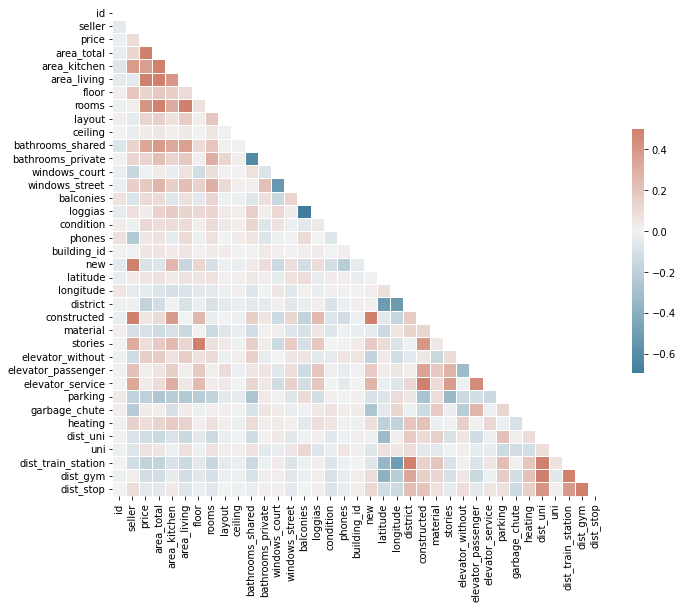

In [12]:
def correlation(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

correlation(train_merged)

### Kitchen size seems to somewhat increase by the year it was constructed

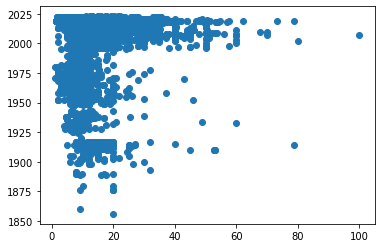

In [13]:
plt.scatter(train_merged.area_kitchen, train_merged.constructed)
plt.show()

### Plotting area total and area living we begin to see artefacts in the data where a lot of apartments that varies in living room size, has a fixed total area

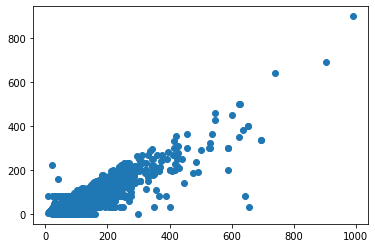

In [14]:
plt.scatter(train_merged.area_total,train_merged.area_living)
plt.show()


## How the data was generated


### How the dataset was split

To understand how the data was split we look into the train vs test dataset.

We start by checking if appartments can be in the same builing in train and test

In [15]:
train_building_ids = train_merged.building_id.unique()
test_building_ids = test_merged.building_id.unique()
print("Intersects: " + str((len(train_building_ids[np.in1d(train_building_ids, test_building_ids)]))))

Intersects: 0


We can see that there is no intersection, this means that the data was generated with a split between the different buildings, and we will not find any buildings in the test set that is also in the train set

## Exploration of individual features

### Price
####  Outlier Removal
By plotting the prices in a histogram and scatterplot, we noticed that there were mainly three extreme outliers.
We first used a function for dropping outliers in smaller percentiles on each end of the spectrum.
The skewness of the data were greatly reduced in the process.

Skewness : 19.152175
Kurtosis : 716.628490


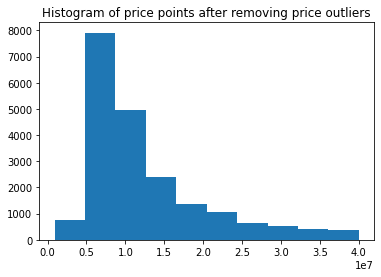

Skewness : 1.565844
Kurtosis : 1.980908


In [16]:
# Remove the extremities
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)

# Analysing skewness and kurt of the target before dropping outliers
print("Skewness : %f" % train_merged['price'].skew())
print("Kurtosis : %f" % train_merged['price'].kurt())

plt.scatter(train_merged["price"],train_merged.area_total)
plt.title("Scatterplot of price by area total")
plt.show()

plt.hist(train_merged["price"])
plt.title("Histogram of price points before removing price outliers")
plt.show()

drop_outliers(train_merged, "price")   # Remove apartments with prices either
                                            # below or above the quarterly percentage
# Data is now more normalized

plt.hist(train_merged["price"])
plt.title("Histogram of price points after removing price outliers")
plt.show()

# Analysing skewness and kurt of the target after dropping outliers
# Skewness - Absence of symmetry from the mean of the dataset
# Kurtosis - Is the distribution more or less peaked than the normal distribution? (Flat vs peaking)
print("Skewness : %f" % train_merged['price'].skew())
print("Kurtosis : %f" % train_merged['price'].kurt())

### Analysing the layout feature
By setting all NaN values to 3 and then using boxplot to analyse the nature of this feature,
we noticed that the different layouts had some clear differences regarding the relationship with price.

<AxesSubplot:xlabel='layout', ylabel='price'>

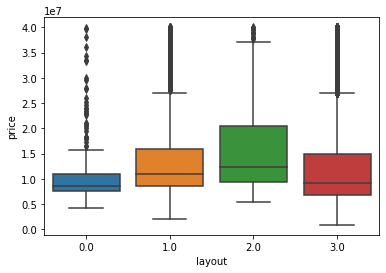

In [17]:
# Set all NaN values to "3" for visualization
train_merged.loc[np.isnan(train_merged["layout"]), "layout"] = 3
sns.boxplot(x=train_merged.layout, y=train_merged.price)


## Exploration of pairs and groups

### Bathrooms

In [ ]:
train_merged[(train_merged.bathrooms_shared == train_merged.bathrooms_private)&(train_merged.bathrooms_private.isna() == False)].bathrooms_shared

11       1.0
29       1.0
43       1.0
59       1.0
76       1.0
        ... 
23190    1.0
23201    1.0
23249    1.0
23264    1.0
23269    1.0
Name: bathrooms_shared, Length: 1233, dtype: float64

<AxesSubplot:xlabel='bathrooms_private', ylabel='price'>

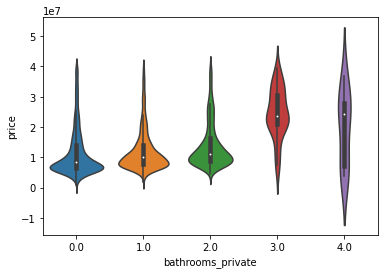

In [ ]:
fig, axes = plt.subplots()
sns.violinplot(x='bathrooms_private',y='price', data=train_merged, ax = axes)

In [ ]:
fig, axes = plt.subplots()
sns.violinplot(x='bathrooms_shared',y='price', data=train_merged, ax = axes)

<AxesSubplot:xlabel='bathrooms_shared', ylabel='price'>

In [ ]:
fig, axes = plt.subplots()
sns.histplot(x='bathrooms_shared', data=train_merged, ax = axes)

<AxesSubplot:xlabel='bathrooms_shared', ylabel='Count'>

In [ ]:
train_merged["bathrooms_sum"] = train_merged.bathrooms_shared + train_merged.bathrooms_private
test_merged["bathrooms_sum"] = test_merged.bathrooms_shared + test_merged.bathrooms_private

<AxesSubplot:xlabel='bathrooms_sum', ylabel='price'>

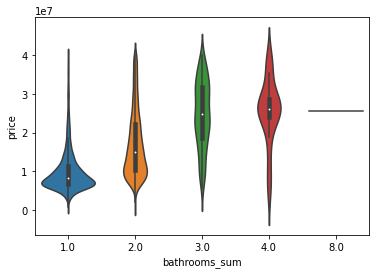

In [ ]:
fig, axes = plt.subplots()
sns.violinplot(x='bathrooms_sum',y='price', data=train_merged, ax = axes)

<AxesSubplot:xlabel='bathrooms_sum', ylabel='price'>

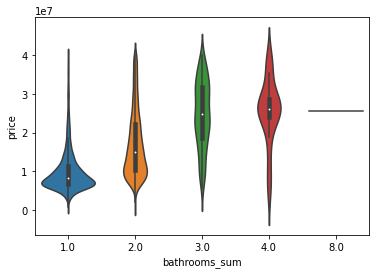

In [ ]:
fig, axes = plt.subplots()
sns.violinplot(x='bathrooms_sum',y='price', data=train_merged, ax = axes)

In [ ]:
train_merged.loc[train_merged.bathrooms_private >=1,"bathrooms_sum"] += 1

#### fill na with mean rounded to closest integer = 1

In [ ]:
train_merged.loc[train_merged.bathrooms_private.isna(),"bathrooms_private"] = 1
train_merged.loc[train_merged.bathrooms_shared.isna(),"bathrooms_shared"] = 1

In [ ]:
test_merged.bathrooms_shared.describe()

count    8220.000000
mean        0.776642
std         0.811608
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: bathrooms_shared, dtype: float64

### Loggias and Balconies

<AxesSubplot:xlabel='loggias', ylabel='price'>

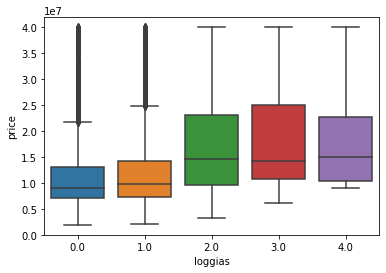

In [ ]:
fig, axes = plt.subplots()
sns.boxplot(x='loggias',y='price', data=train_merged, ax = axes)

<AxesSubplot:xlabel='balconies', ylabel='price'>

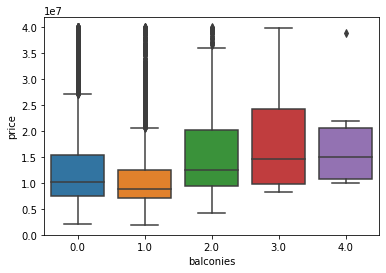

In [ ]:
fig, axes = plt.subplots()
sns.boxplot(x='balconies',y='price', data=train_merged, ax = axes)

In [ ]:
train_merged.loc[train_merged.balconies.isna(),["balconies","loggias"]] = 0
train_merged["bal_log_sum"] = train_merged.loggias + train_merged.balconies

<AxesSubplot:xlabel='bal_log_sum', ylabel='price'>

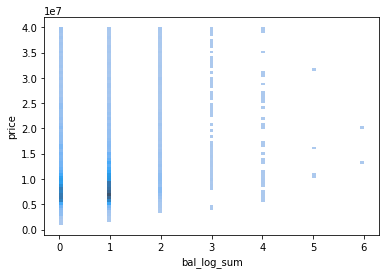

In [ ]:
fig, axes = plt.subplots()
sns.histplot(x='bal_log_sum',y='price', data=train_merged, ax = axes)

In [ ]:
train_merged[train_merged.loggias == 2].building_id

59       5993
381      1371
415      2086
425      2969
495      3655
         ... 
23067    1143
23100    2974
23226    8191
23240     715
23265    5404
Name: building_id, Length: 765, dtype: int64

In [ ]:
train_merged.loc[train_merged.building_id==8191,["loggias", "floor","balconies"]]

loggias  floor  balconies
2356       0.0    2.0        1.0
16639      1.0    7.0        0.0
20366      1.0    7.0        0.0
23226      2.0    5.0        0.0
23227      1.0    9.0        0.0

<AxesSubplot:xlabel='floor', ylabel='Count'>

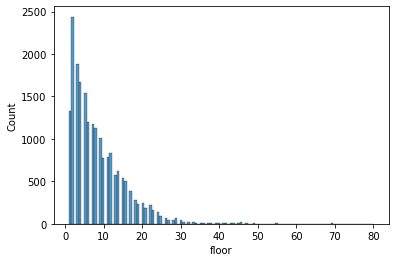

In [ ]:
fig, axes = plt.subplots()
sns.histplot(x='floor', data=train_merged, ax = axes)

In [ ]:
train_merged.floor.describe()

count    20440.000000
mean         8.568102
std          7.267317
min          1.000000
25%          3.000000
50%          7.000000
75%         12.000000
max         80.000000
Name: floor, dtype: float64

<AxesSubplot:xlabel='seller', ylabel='price'>

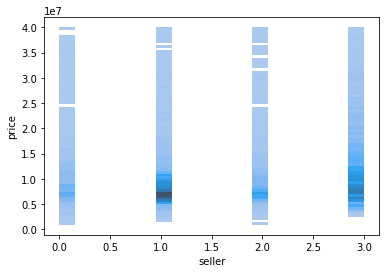

In [ ]:
fig, axes = plt.subplots()
sns.histplot(x='seller',y="price", data=train_merged, ax = axes)

<AxesSubplot:xlabel='condition', ylabel='Count'>

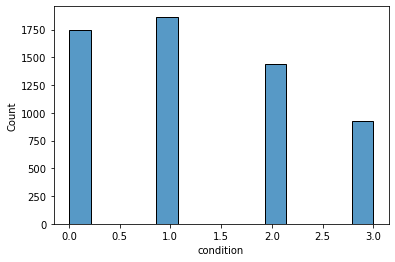

In [ ]:
fig, axes = plt.subplots()
sns.histplot(x='condition', data=test_merged, ax = axes)


<AxesSubplot:xlabel='material', ylabel='area_total'>

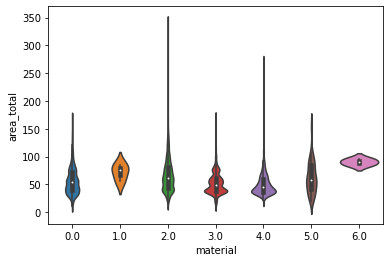

In [ ]:
fig, axes = plt.subplots()
sns.violinplot(x='material',y='area_total', data=train_merged, ax = axes)

[nan  3.  2.  0.  1.]



<AxesSubplot:xlabel='condition', ylabel='price'>

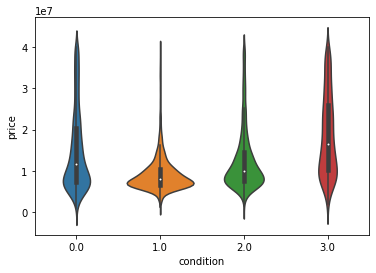

In [ ]:
print(train_merged.condition.unique())
print()
fig, axes = plt.subplots()
sns.violinplot(x='condition',y='price', data=train_merged, ax = axes)


## Cleaning of features

In [ ]:
import numpy as np
import pandas as pd
import Tools
import json
import LightGBM as lg

### Remove outliers by percentage
This function was used to remove outliers in the lower 10 percentile and the upper 80 percentile.
Looking at the extreme outliers, we expected this to give better results initially, but it rather
made the result worse. (before we log2 transformed the target variable)

In [ ]:
def drop_outliers(df, field_name):
    upper = 80  # Percentile
    lower = 10  # Percentile
    iqr = 1.5 * (np.percentile(df[field_name], upper) - np.percentile(df[field_name], lower))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], upper))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], lower) - iqr)].index, inplace=True)

### Bin distances to reduce overfit
To avoid the model overfitting on the building locations by using latitude and longtitude, we decided
to bin the distance from center variable into far, medium and close. This in turn most probably lead to
underfitting and was not useful.

In [ ]:
def distance_binning(df):
    conditions = [
        (df.dist_from_center <= 5),
        (df.dist_from_center <= 15),
        (df.dist_from_center > 15)
    ]

    values = ['close', 'medium', 'far']
    df["close_med_far"] = np.select(conditions, values)

    df = pd.get_dummies(df, columns=["close_med_far"], dummy_na=True, prefix="dist")
    df = df.drop(columns=["dist_from_center"])
    df = df.drop(columns="dist_nan")
    return df

### Tried to use the other appartments in the same building to fill missing values
As there were alot of missing features in the dataset, and we could not fill all of them by looking at
patterns or general data cleaning. Therefore, a function for filling NaN values (after initial data cleaning)
with the averages of the building that the apartment were in. We figured that many of the apartments within the same
building most likely had the same features. The performance of this varied quite alot, so we most likely
drew the wrong conclusion here and implemented a pattern which should not have been there.
Removing this feature for the end prediction resulted in better performance

In [ ]:

# Fills in building related information within each building. Sets average for ceiling and average nearest integer
# for the rest
def fillna_building_average(train,test):
    j = 0
    for i in np.unique(train.building_id):
        j += 1
        if not j % 500:
            print(j)
        train.loc[train.building_id == i, "windows_court"] = train.loc[train.building_id == i, "windows_court"].fillna(
            np.rint(Tools.get_mean(train,test,"windows_court")))
        train.loc[train.building_id == i, "windows_street"] = train.loc[train.building_id == i, "windows_street"].fillna(
            np.rint(Tools.get_mean(train,test,"windows_street")))
        train.loc[train.building_id == i, "bathrooms_shared"] = train.loc[
            train.building_id == i, "bathrooms_shared"].fillna(
            np.rint(Tools.get_mean(train,test,"bathrooms_shared")))
        train.loc[train.building_id == i, "bathrooms_private"] = train.loc[
            train.building_id == i, "bathrooms_private"].fillna(
            np.rint(Tools.get_mean(train,test,"bathrooms_private")))
        train.loc[train.building_id == i, "ceiling"] = train.loc[train.building_id == i, "ceiling"].fillna(
            Tools.get_mean(train,test,"ceiling"))
        train.loc[train.building_id == i, "balconies"] = train.loc[train.building_id == i, "balconies"].fillna(
            np.rint(Tools.get_mean(train,test,"balconies")))
        train.loc[train.building_id == i, "loggias"] = train.loc[train.building_id == i, "loggias"].fillna(
            np.rint(Tools.get_mean(train,test,"loggias")))
        train.loc[train.building_id == i, "layout"] = train.loc[train.building_id == i, "layout"].fillna(
            np.rint(Tools.get_mean(train,test,"layout")))

        train.loc[train.building_id == i, "area_kitchen"] = train.loc[train.building_id == i, "area_kitchen"].fillna(
            Tools.get_mean(train, test, "area_kitchen"))
        train.loc[train.building_id == i, "area_living"] = train.loc[train.building_id == i, "area_living"].fillna(
            Tools.get_mean(train, test, "area_living"))

### Tried to fill missing values by the mean of the same districs
After filling NaN values with the building average, we noticed that there were still some missing value.
These were filled in using the district average, but did not result in good performance as it generalized
way too much.

In [ ]:
def fillna_district_average(train,test):
    j = 0
    for i in np.unique(train.district):
        j += 1
        if not j % 500:
            print(j)
        train.loc[train.district == i, "windows_court"] = train.loc[train.district == i, "windows_court"].fillna(
            np.rint(Tools.get_mean(train,test,"windows_court")))
        train.loc[train.district == i, "windows_street"] = train.loc[train.district == i, "windows_street"].fillna(
            np.rint(Tools.get_mean(train,test,"windows_street")))
        train.loc[train.district == i, "bathrooms_shared"] = train.loc[train.district == i, "bathrooms_shared"].fillna(
            np.rint(Tools.get_mean(train,test,"bathrooms_shared")))
        train.loc[train.district == i, "bathrooms_private"] = train.loc[train.district == i, "bathrooms_private"].fillna(
            np.rint(Tools.get_mean(train,test,"bathrooms_private")))
        train.loc[train.district == i, "ceiling"] = train.loc[train.district == i, "ceiling"].fillna(
            Tools.get_mean(train,test,"ceiling"))
        train.loc[train.district == i, "balconies"] = train.loc[train.district == i, "balconies"].fillna(
            np.rint(Tools.get_mean(train,test,"balconies")))
        train.loc[train.district == i, "loggias"] = train.loc[train.district == i, "loggias"].fillna(
            np.rint(Tools.get_mean(train,test,"loggias")))
        train.loc[train.district == i, "layout"] = train.loc[train.district == i, "layout"].fillna(
            np.rint(Tools.get_mean(train,test,"layout")))

        train.loc[train.district == i, "seller"] = train.loc[train.district == i, "seller"].fillna(
            np.rint(Tools.get_mean(train,test,"seller")))
        train.loc[train.district == i, "area_kitchen"] = train.loc[train.district == i, "area_kitchen"].fillna(
            Tools.get_mean(train,test,"area_kitchen"))
        train.loc[train.district == i, "area_living"] = train.loc[train.district == i, "area_living"].fillna(
            Tools.get_mean(train,test,"area_living"))
        train.loc[train.district == i, "condition"] = train.loc[train.district == i, "condition"].fillna(
            np.rint(Tools.get_mean(train,test,"condition")))
        train.loc[train.district == i, "constructed"] = train.loc[train.district == i, "constructed"].fillna(
            np.rint(Tools.get_mean(train,test,"constructed")))
        train.loc[train.district == i, "material"] = train.loc[train.district == i, "material"].fillna(
            np.rint(Tools.get_mean(train,test,"material")))
        train.loc[train.district == i, "garbage_chute"] = train.loc[train.district == i, "garbage_chute"].fillna(
            np.rint(Tools.get_mean(train,test,"garbage_chute")))
        train.loc[train.district == i, "heating"] = train.loc[train.district == i, "heating"].fillna(
            np.rint(Tools.get_mean(train,test,"heating")))


        # Unsure:

        train.loc[train.district == i, "parking"] = train.loc[train.district == i, "parking"].fillna(
            np.rint(Tools.get_mean(train,test,"parking")))


### Set missing parking to a unique value 3
As there were alot of NaNs we decided to set all NaNs to their own value, to see if sellers
possibly would register a type of parking as NaN (or maybe NaN is simply no parking)


In [ ]:
def clean_parking(df):
    df.parking.fillna(3, inplace=True)
    return df

### Clean garbage chute

In [ ]:
def clean_garbage_chute(df):
    df.garbage_chute.fillna(1, inplace=True)
    return df

### Remove outliers that are outside of moscow

In [ ]:
def clean_distance_to_center(df):  # Remove outliers in distance
    df.loc[df.dist_from_center > 75, "dist_from_center"] = np.mean(df["dist_from_center"])

### Tested if dropping layout was good
We ended up cleaning and setting Layout to mode. This made the feature usable.

In [ ]:
def drop_layout(df):
    return df.drop(columns=["layout"])

### tried to drop low importance features
We extracted the feature importances and removed the features with the lowest 20th percentile.
This did not improve performance most likely due to underfitting or removing useful information.

In [ ]:
def drop_low_importance(df):
    df = df.drop(columns=["street", "address"])
    df = df.copy()
    Y = df["price"]
    X = df.drop(columns="price")

    zero_features, feature_importances = lg.identify_zero_importance_features(X, Y, iterations=2)
    print(feature_importances)

    feature_importances.describe()
    pp = np.percentile(feature_importances['importance'], 20)

    to_drop = feature_importances[feature_importances['importance'] <= pp]['feature']

    return to_drop

### tried to drop features that had high correlation
Using too many correlating features could lead to worse model performance, so we analysed the features with highest correlation
and dropped them. This did not lead to good performance.

In [ ]:
def drop_high_correlation(df):
    threshold = 0.78

    # Absolute value correlation matrix
    corr_matrix = df.corr().abs()

    # Upper triangle of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(to_drop)

    return to_drop

### tried to generate ohe values for feature condition


In [ ]:
def dummys_generator(df):
    return pd.get_dummies(df, columns=["condition"], dummy_na=True, prefix="Cond")

### filled the mean of bathrooms

In [ ]:
def fill_bathrooms_mean(df):
    df.loc[df.bathrooms_shared.isna(),["bathrooms_shared"]] = 1
    df.loc[df.bathrooms_private.isna(),["bathrooms_private"]] = 1

### Clean feature new


In [ ]:
def clean_feature_new(df) -> None:
    """
    Some values of new are set to 1, when the construction date is more than 10 years old. And some are not set at all.
    This function fixes these values to correspond to the correct construction year.

    """
    # if new == 1 (True), but the construction year is old, set new == 0
    # update the values that dont have new but have constructed
    df.loc[(df.new.isna()) & (df.constructed < 2010), "new"] = 0
    df.loc[((df.new.isna()) & (df.constructed >= 2010)), "new"] = 1

    # update the values that have new == 1 but are from before 2010 to 0 and vice versa
    df.loc[(df.constructed >= 2010), "new"] = 1
    df.loc[(df.constructed < 2010), "new"] = 0

### Cleaning of constructed
Decided on a date for when the appartment should be new, and when it is old.

We also tried to do some age binning, but got worse results as a consequence

In [ ]:
def set_means_constructed(df, new_mean, construced_mean):
    # for new buildings
    df.loc[((df.constructed.isna()) & (df.new == 1)), "constructed"] = new_mean
    # for old buildings
    df.loc[((df.constructed.isna()) & (df.new == 0)), "constructed"] = construced_mean

    # when new is unknown
    # set it to the mean
    df.loc[(df.constructed.isna()), "constructed"] = construced_mean
    # clustering???

In [ ]:
def clean_feature_constructed(df_train: pd.DataFrame, df_test: pd.DataFrame) -> pd.DataFrame:
    """
    Set date for missing nan values to the mean based on if the appartment is new or not.
    """

    after_2009_mask_train = (df_train.constructed > 2009)
    after_2009_mask_test = (df_test.constructed > 2009)

    # find mean of train and test
    construced_mean = Tools.get_mean(df_train,df_test,"constructed")
    new_mean = Tools.get_mean(df_train[after_2009_mask_train],df_test[after_2009_mask_test],"constructed")

    ## When new is known
    set_means_constructed(df_train, construced_mean, new_mean)
    set_means_constructed(df_test, construced_mean, new_mean)

        # create very_new, new, old, very_old
    #df_train = create_column_age(df_test, df_train)
    #df_test = create_column_age(df_train, df_test)

    return (df_train, df_test)

In [ ]:
def clean_feature_constructed_single(df_train: pd.DataFrame, df_test: pd.DataFrame) -> pd.DataFrame:
    """
    Set date for missing nan values to the mean based on if the appartment is new or not.
    """

    after_2009_mask_train = (df_train.constructed > 2009)
    after_2009_mask_test = (df_test.constructed > 2009)

    # find mean of train and test
    construced_mean = (df_train.constructed.sum() + df_test.constructed.sum()) / (
                df_train.constructed.count() + df_test.constructed.count())
    new_mean = (df_train[after_2009_mask_train].constructed.sum() + df_test[after_2009_mask_test].constructed.sum()) / (
            df_train[after_2009_mask_train].constructed.count() + df_test[after_2009_mask_test].constructed.count())

    ## When new is known
    set_means_constructed(df_train, construced_mean, new_mean)

        # create very_new, new, old, very_old
    #df_train = create_column_age(df_test, df_train)

    return (df_train)

In [ ]:
def create_column_age(df_test, df_train):
    """
    make constructed into age
    then age into bins
    then bins into dummies,
    """
    df_train["age"] = ((df_train.constructed - max([df_train.constructed.max(), df_test.constructed.max()])) * -1)
    df_train["age"] = pd.cut(df_train.age, [-1, 10, 20, 40, 500], labels=["very_new", "new", "old", "very_old"])
    df_train = pd.get_dummies(df_train, columns=["age"], dummy_na=True)
    return df_train

### Clean ceiling
From our eda we found out that the ceiling sometimes was in the hundreds and assume that the ones inputting it used cm instead of meter.

We also found that ceiling was linked to material and condition so we fixed some Nans from that

In [ ]:
def clean_feature_ceiling(df_train: pd.DataFrame, df_test: pd.DataFrame) -> None:
    """
    Clean feature ceiling
    # some had ceiling at > 200, meaning that they tought ceiling was in cm, and not meter.
    Others that where nan, above 10 meter ceiling height or below 1 meter are set to the mean.
    """
    df_train.loc[df_train.ceiling > 50, "ceiling"] /= 100
    df_test.loc[df_test.ceiling > 50, "ceiling"] /= 100

    df_train.loc[df_train.ceiling > 25, "ceiling"] /= 10
    df_test.loc[df_test.ceiling > 25, "ceiling"] /= 10

    df_train.loc[df_train.ceiling < 0.5, "ceiling"] = float('NaN')
    df_test.loc[df_test.ceiling < 0.5, "ceiling"] = float('NaN')

    # see that we can fill ceilings that are low, and use material 3 and 4 can be set to a sample of material 3 and 4
    df_train = clean_ceiling_by_material(df_train)
    df_test = clean_ceiling_by_material(df_test)

    # see that we can fill ceilings that are low, and use that condition 1 can be set to a sample of condtion 1
    df_train = clean_ceiling_by_condition(df_train)
    df_test = clean_ceiling_by_condition(df_test)

    ceiling_mean = (df_train.ceiling.sum() + df_test.ceiling.sum()) / (
                df_train.ceiling.count() + df_test.ceiling.count())

    df_train.loc[df_train.ceiling.isna(),"ceiling"] = ceiling_mean
    df_test.loc[df_test.ceiling.isna(),"ceiling"] = ceiling_mean

In [ ]:
def clean_ceiling_by_material(df):
    # see that we can fill ceilings that are low, and use material 3 and 4 can be set to a sample of material 3 and 4
    mask = ((df.material == 4)| (df.material == 3)) & df.ceiling.isna()
    # 2.67 is the mean of material 3 and 4
    # samle just the low ceiling appartments
    df.loc[mask,"ceiling"] = df[df.ceiling < 2.67].ceiling.sample(n=len(df[mask]),replace=True).to_numpy()
    return df

In [ ]:
def clean_ceiling_by_condition(df):
    # see that we can fill ceilings that are low, and use that condition 1 can be set to a sample of condtion 1
    mask = ((df.condition == 1) & (df.ceiling.isna()))
    # 2.67 is the mean of material 3 and 4
    # samle just the low ceiling appartments
    df.loc[mask,"ceiling"] = df[df.ceiling < 2.67].ceiling.sample(n=len(df[mask]),replace=True).to_numpy()
    return df

### Clean feature heating
When plotting heating we found that some fit togheter, but got worse/ or similar score from using this.

In [ ]:
def clean_feature_heating(df: pd.DataFrame) -> pd.DataFrame:
    """
    The heating varable has a lot of missing values. The ones that are missing have a distribution close to the one of heating type 0, 1 and 3.
    Therefore we box groups 0, 1 and 3 together and assign all nans to that same group.
    """
    df.loc[(df.heating == 0) | (df.heating == 3), "heating"] = 1

    df = pd.get_dummies(df, columns=['heating'], dummy_na=True)
    return df

### Clean areas
Cleaning of areas comes from the EDA where we found that a lot of builings might have wrong reports on their values.
We set areas to mean, but some we fixed more

In [ ]:
def clean_areas(df_train: pd.DataFrame, df_test: pd.DataFrame):
    """
    Some area_living = 0, so set it to the mean percentage of living/total.
    kitchen that is na probably has a kitchen of atleast 1 squaremeter.
    """
    # merge datasets
    prices = df_train.price
    df = df_train.drop("price",axis=1).append(df_test).copy()

    mask = (df.area_living.isna() | (df.area_living == 0))
    df.loc[mask, "area_living"] = df.loc[mask, "area_total"].values * 0.581517

    mask = (df.area_kitchen.isna() | (df.area_kitchen == 0))
    df.loc[mask, "area_kitchen"] = df.loc[mask, "area_living"].values * 0.357147

    mask = (df.area_living > df.area_total)
    df.loc[mask,["area_living"]] = df.loc[mask,["area_total"]].values

    # if kitchen is bigger than living, we found that the kitchen_area was most likely not calculated as part of the living area.
    mask = (df.area_kitchen > df.area_living)
    df.loc[mask, "area_living"] += df.loc[mask, "area_kitchen"]

    # obvious mistake
    df.loc[df.id== 1107,"area_total"] *= 10

    # clean 103 rows
    mask = (df.area_living > df.area_total) & (df.area_living == 80)
    df.loc[mask,"area_living"] *= (df[mask].area_total * 0.01)

    # flip the rest
    mask = (df.area_living > df.area_total)
    df.loc[mask, ["area_living","area_total"]] = df.loc[mask, ["area_total","area_living"]].values


    areas = [10, 20, 25, 30, 35, 40, 50]
    for area in areas:
        mask = (df.area_kitchen == area)
        df.loc[mask, "area_kitchen"] *= df.loc[mask, "area_living"] * 0.01


    # can try this instead of just areas sometime:)
    # df["area_kitchen"] *= df["area_living"] * 0.01

    # split back
    df_train = df.iloc[:len(df_train)].copy()
    df_train["price"] = prices.values
    df_test =  df.iloc[len(df_train):].copy()

    return df_train, df_test

### Set bathrooms to mean

In [ ]:
def clean_bathrooms(df_train: pd.DataFrame, df_test: pd.DataFrame) -> None:
    """
    Set bathrooms to 1

    """
    fill_bathrooms_mean(df_train)
    fill_bathrooms_mean(df_test)

### balconies and loggias
We tought that balconies and loggias could both be set to 0

In [ ]:
def clean_balconies_loggias(df: pd.DataFrame) -> None:
    df.loc[df.balconies.isna(), ["balconies","loggias"]] = 0

### Missing districts
Some did not have district, so we found the closest builing, and set the district to be the same,

Here we also fix some lat lons that were wrong

In [ ]:
# Finds closest district using coordinates
def find_closest_district(df):

    # All ids with empty district
    var = np.asarray(df.loc[df.district.isna(), "id"])

    # All rows with empty district
    rows_no_dist = df[df.id.isin(var)]

    # List with all longitude and latitude values in dataframe
    data_longlat = list(zip(df.latitude, df.longitude))

    known_streets = ["улица Центральная", "Бунинские Луга ЖК", "улица 1-я Линия"]
    # Remove  own coordinates
    for i in range(len(var)):
        n = rows_no_dist.loc[rows_no_dist["id"] == var[i]].index[0]
        data_longlat[n] = (float("nan"), float("nan"))


    copy =  data_longlat.copy()
    for j in range(len(var)):
        # Temp variable for coordinate with empty district
        if df.loc[df["id"] == var[j]].street.values[0] == known_streets[0]:
            df.at[df.loc[df["id"] == var[j]].index[0], "latitude"] = 55.610910522687554
            df.at[df.loc[df["id"] == var[j]].index[0], "longitude"] = 37.28814356811611
            df.at[df.loc[df["id"] == var[j]].index[0], "district"] = 11.0
            continue

        if df.loc[df["id"] == var[j]].street.values[0] == known_streets[1]:
            df.at[df.loc[df["id"] == var[j]].index[0], "latitude"] = 55.54382960763567
            df.at[df.loc[df["id"] == var[j]].index[0], "longitude"] = 37.48237108490257
            df.at[df.loc[df["id"] == var[j]].index[0], "district"] = 11.0
            continue

        if df.loc[df["id"] == var[j]].street.values[0] == known_streets[2]:
            df.at[df.loc[df["id"] == var[j]].index[0], "latitude"] = 55.6297901894583
            df.at[df.loc[df["id"] == var[j]].index[0], "longitude"] = 37.1461596771594
            df.at[df.loc[df["id"] == var[j]].index[0], "district"] = 11.0
            continue

        a = (float(df.loc[df["id"] == var[j]].latitude), float(df[df["id"] == var[j]].longitude))

                
        if a == (55.59516, 37.741109):
            df.at[df.loc[df["id"] == var[j]].index[0], "district"] = 11.0
            continue

        print("", a)#, df.loc[df["id"] == var[j]].street, df.loc[df["id"] == var[j]].address)
        if df.loc[df["id"] == var[j]].street.values[0] not in known_streets and not np.isnan(a[0]):


            # Select the row with nearest longitude and latitude
            nearest = min(copy, key=lambda x: distance(x, a))

            while np.isnan(df.iloc[[copy.index(nearest)]].district.values[0]):
                copy.remove(nearest)
                nearest = min(copy, key=lambda x: distance(x, a))

            # Set closest district
            df.at[df.loc[df["id"] == var[j]].index[0], "district"] = df.iloc[[copy.index(nearest)]].district.values[0]
            copy =  data_longlat.copy()

In [ ]:
# Calculates distance using pythagoras
def distance(co1, co2):
    return np.sqrt(pow(abs(co1[0] - co2[0]), 2) + pow(abs(co1[1] - co2[1]), 2))

### function that does some removal and cleans to the average, we made a more general one under

In [ ]:
def feature_clean_average(df):
    # Generate column "distance from centrum"
    newcords=Tools.haversine([df.latitude.values, df.longitude.values],unit="km")
    df['dist_from_cent'] = newcords
    df = distance_binning(df)

    # Drop layout
    df = df.drop(columns=["layout"])
    df["elevator_passenger"].value_counts()

    # Fill parking and garbage
    df['parking']=df['parking'].fillna(df['parking'].mode()[0])
    clean_garbage_chute(df)

    # Fill area
    df['area_kitchen']=df['area_kitchen'].fillna(df['area_kitchen'].mean())
    df['area_living']=df['area_living'].fillna(df['area_living'].mean())

    # Fill heating, material,seller and windows
    df['heating']=df['heating'].fillna(df['heating'].mode()[0])
    df['material']=df['material'].fillna(df['material'].mode()[0])
    df['seller']=df['seller'].fillna(df['seller'].mode()[0])
    df['windows_court']=df['windows_court'].fillna(df['windows_court'].mode()[0])
    df['windows_street']=df['windows_street'].fillna(df['windows_street'].mode()[0])

    # If data is missing any districts use closest coordinates to find district
    #if df['district'].isnull().values.any():
    #    find_closest_district(df)
    # Find district with coords

    # Fill elevator data
    df["elevator_service"]=df['elevator_service'].fillna(df['elevator_service'].mode()[0])
    df["elevator_without"]=df['elevator_without'].fillna(df['elevator_without'].mode()[0])
    df["elevator_passenger"]=df['elevator_passenger'].fillna(df['elevator_passenger'].mode()[0])

### Clean features to the Mode based on train and test datasets

In [ ]:
def feature_clean_average_both(df_train, df_test):
    # merge datasets
    prices = df_train.price
    df = df_train.drop("price",axis=1).append(df_test).copy()

    ### MODE ###
    columns= ["parking", "heating", "material", "seller", "windows_court", "windows_street", "elevator_without", "elevator_service", "elevator_passenger", "garbage_chute", "loggias", "balconies", "bathrooms_shared", "bathrooms_private", "layout"]

    for column in columns:
        df.loc[df[column].isna(),column] = df[column].mode()[0]

    # If data is missing any districts use closest coordinates to find district
    #if df['district'].isnull().values.any():
        #find_closest_district(df)

    # split back
    df_train = df.iloc[:len(df_train)].copy()
    df_train["price"] = prices.values
    df_test =  df.iloc[len(df_train):].copy()

    return df_train, df_test



# Feature Engineering

## Feature Creation

For the feature engineering, we looked at both the domain knowledge and combination of other features.

### Distance features
As described in the section regarding domain knowledge, we used the retrieved datasets for locations for
metros, universities, parks, tranport hubs, train stations, gyms, surface transport stops, stadiums and water
facilities.
[metro, train, gym, hub, center, ]
#### We used the following code structure for every location in the external datasets, which retrieved the distance to the closest location to every building location (See "Domain Knowledge" section for more)

In [6]:
def metro_dist(data):
    geojson = pd.read_json('data/response.json')
    metros = pd.json_normalize(geojson["features"])
    metros = metros.drop(columns=["type","geometry.type","properties.DatasetId"])
    metros = metros.rename(columns={"geometry.coordinates": "loc", "properties.Attributes.global_id" : "id"})
    metros = metros[['id','loc']]
    metros[["lat", "long"]] = pd.DataFrame(metros["loc"].tolist(), columns=["lat", "long"])
    metros = metros.drop(columns="loc")

    dist = None
    for idx in data.building_id:
        dist = haversine([metros.lat.values,metros.long.values], [data.loc[data.building_id == idx, "longitude"].unique(), data.loc[data.building_id == idx, "latitude"].unique()],unit="m")
        data.loc[data.building_id == idx, "dist_metro"] = dist.min()

    return data

#### Distance to city centre (the red square)
Plotting the train prices on a map showed a good correlation with how far the apartments were located
from the city centre, which we concluded with being the famous red square (coordinates: 55.754093, 37.620407)
Therefore, we gathered the distances for all the apartment complexes to the red square which resulted in an
important feature.

In [7]:
def haversine(points1, points2=(55.754093, 37.620407), unit='km'):
	avg_earth_radius = _get_avg_earth_radius(unit)

	points2 = np.radians(points2)

	lat1, lon1 = np.radians(points1[0]), np.radians(points1[1])
	lat2, lon2 = points2[0], points2[1]

	lat_diff = lat1 - lat2
	lon_diff = lon1 - lon2

	d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff * 0.5) ** 2

	return 2 * avg_earth_radius * np.arcsin(np.sqrt(d))

train_merged.loc[:,"dist_from_center"] = haversine([train_merged.latitude.values, train_merged.longitude.values], unit="km")

#### Combination of distances
Since adding the other distances than metro entrance and university distance resulted in worse performance,
we attempted to create an average closeness score of the distances to parks, transport hubs, train stations,
gyms, stadiums and surface transport stops. The intention behind this was for the tree based models to
split based on this one feature rather than multiple insignificant ones.
We tried to include all distances (including metro and uni) in this average, but every attempt led to worse performance.

In [ ]:
def average_dist(data):
    data["avg_dist"] = (data.dist_parks +
                        data.dist_hub +
                        data.dist_train_station +
                        data.dist_gym +
                        data.dist_stadiums +
                        data.dist_stop)/8
    data = data.drop(columns=[
                              "dist_parks",
                              "dist_hub",
                              "dist_train_station",
                              "dist_gym",
                              "dist_stadiums",
                              "dist_stop"])
    return data


### High apartment feature
It is reasonable to assume that an apartment that is located high up in a building gets a better view and
perhaps a higher price point to follow (penthouses for example). So we constructed a function for calculating
the exponential value of the floor/max stories ratio in order to exaggerate this feature for the tree models.
In case any floors were higher than max floor, we set them as the highest floor (1/1)

In [8]:
def high_appartment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Boolean if the appartment is high up or not in relation to floor and stories
    """
    height = df.floor.divide(df.stories)
    high_exp = np.exp(height) - 1
    e = np.exp(1)

    df['high'] = high_exp
    df['high'].where(df['high'] > e, e)

    return df

### Is the apartment in the middle of the building?
We might have been too ambitious with the high apartment feature, and forgot that there might be a lot of old buildings
where this logic does not apply. We found an article that stated that in old apartment complexes of Moscow (outside of city centre), apartments that are on the very top
and very bottom might have some issues. For the top apartments, water might leak in due to damaged or bad roof. For the
bottom apartments you get no heat from the nonexistent inhabitant below, meaning that you would spend a lot of
energy to keep warm (and the inhabitant above you warm).

In [9]:
def middle(df:pd.DataFrame) -> pd.DataFrame:
    """
    Boolean 1 if the appartment is not floor 1 or top floor
    """
    df["middle"] = 1

    mask = (df.floor == df.stories) | (df.floor == 1)
    # set to 0
    df.loc[mask,"middle"] = 0
    return df

### Sqm2 difference between kitchen area and total area
We tried to see if there could be any correlation with the size differences of the kitchen area and the total area
with the price. The room size were also looked at by dividing the living area on the number of rooms.

In [10]:
def sq_diff(data):
    data["sq_diff"] = data.area_total - data.area_kitchen
    data["room_size"] = data.area_living/data.rooms
    return data


### Other aggregations of features

In [11]:
# area/ avstand til røde plass
train_merged["area_by_dist"] = train_merged.area_living.divide(train_merged.dist_from_center)
test_merged["area_by_dist"] = test_merged.area_living.divide(test_merged.dist_from_center)

AttributeError: 'DataFrame' object has no attribute 'dist_from_center'

In [ ]:
# area * etasje / avstand
train_merged["area_and_floor_by_dist"] = train_merged.area_living.multiply(train_merged.floor).divide(train_merged.dist_from_center)
test_merged["area_and_floor_by_dist"] = test_merged.area_living.multiply(test_merged.floor).divide(test_merged.dist_from_center)

### District average price
The average district price were created and explored, to see if there were any correlation, but this feature
did not perform well. Most likely due to the data leakage into the test set, and that test set contains different buildings.

In [ ]:
def district_avg_price(data, data_test):
    for idx in data.district.unique():
        data.loc[data.district == idx, "avg_price"] = np.mean(data.price)/np.mean(data.total_area)
        data_test.loc[data_test.district == idx, "avg_price"] = np.mean(data.price)/np.mean(data.area)
    return data, data_test

### One hot encoding
helper function to create one hot encoding for many columns at once

In [ ]:
def create_dummies(df: pd.DataFrame, columns) -> pd.DataFrame:
    return pd.get_dummies(df, columns=columns, dummy_na=True)

### Batroom SUM
### Summarizing bathrooms private and shared
Since an appartment usually does not have both private and shared bathrooms, we tried
summing these into a singular variable. Balconies and loggias also had considerable correlation with each other.

In [ ]:
def create_bathroom_sum(df: pd.DataFrame) -> None:
    """
    Create column for the sum of private and shared bathrooms
    """
    df["bathroom_sum"] = df.bathrooms_private + df.bathrooms_shared

    # if the appartment have a private bathroom add 1?
    # df.loc[df.bathroom_private == 1, "bathroom_sum"] += 1

### Summarizing balconies and loggias
Each loggias and balconies weren't initially important features according to feature importance,
so we experimented with summing them together for a composite feature

In [ ]:
def create_bal_log_sum(df: pd.DataFrame) -> None:
    df["bal_log_sum"] = df.loggias + df.balconies

## Log of price

The price is pretty skewed because of some appartments high cost.

Therefor we have to transform the target

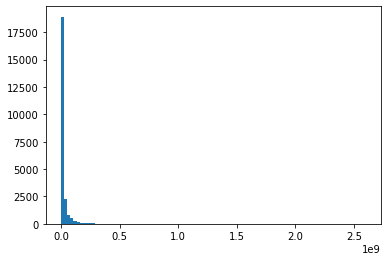

In [13]:
### Price before transform
plt.hist(train_merged.price,100)
plt.show()

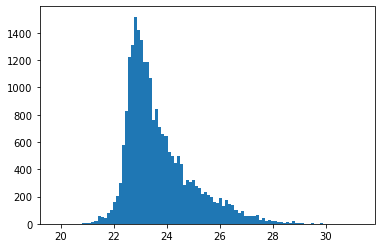

In [11]:
### Price after
### Price before transform
plt.hist(np.log2(train_merged.price),100)
plt.show()

In [ ]:
train_log = train_merged.copy()
train_log.price = np.log2(train_log.price)

## Feature Selection

### removal of features

We remove feature like street, address and phones because they give little to negative information

We remove building id so that we dont overfit to appartments that are in the same building

We remove area_living and area_kitchen because they correlate a lot with area_total

We also remove phones, because we found it to give no information

In [ ]:
droppers = ["id", "street", "address", "phones", "building_id", "area_living", "area_kitchen"]

We also manually tried to remove other features to test if they where needed or not, but got a lot of different results, but in the end we got best results with removing these features

## Recursive feature elimination with cross validation

This can not be run, but has been run to show the results and how it was done

In [ ]:
y = train_log.price
X = train_log.drop(droppers + ["price"], axis=1).copy()
estimator = XGBRegressor(random_state=10, n_estimators = 4000, learning_rate = 0.005, subsample = 0.8, max_depth = 7, alpha = 0.1, min_child_weight=5)
selector = RFECV(estimator,step=1,cv=GroupKFold(n_splits=10), min_features_to_select=1, scoring='neg_mean_squared_log_error')
selector.fit(X, y, groups=groups)  

RFECV(cv=GroupKFold(n_splits=10),
      estimator=XGBRegressor(alpha=0.1, base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=0.005,
                             max_delta_step=None, max_depth=7,
                             min_child_weight=5, missing=nan,
                             monotone_constraints=None, n_estimators=4000,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=10, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=0.8,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      scoring='neg_mean_squared_log_error')

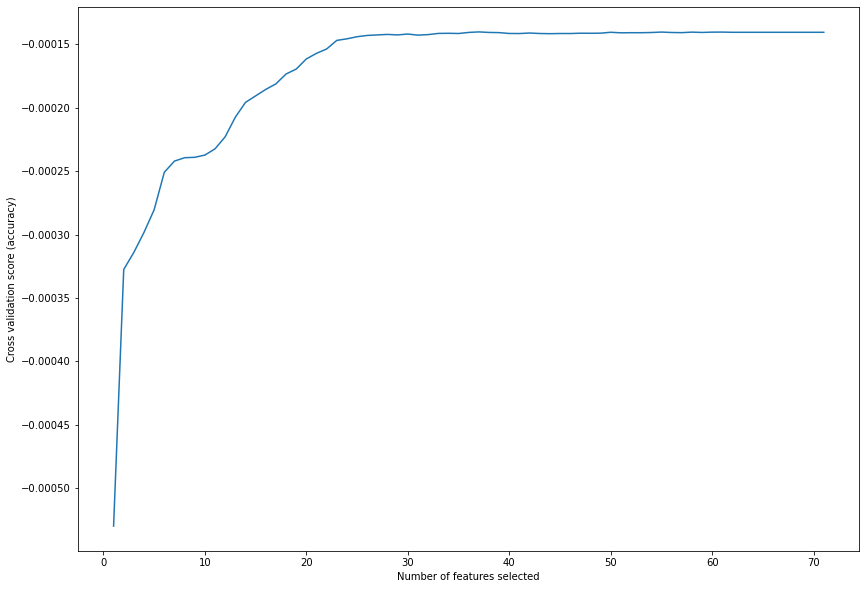

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show()

In [ ]:
selector.ranking_

array([ 1,  9,  1,  1, 23, 15, 24, 16, 12, 11, 10,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  4,  1,  1, 13, 32, 18, 14,  8,  1, 34,  1, 33,
        3,  2,  1,  1, 30, 28,  1,  7,  1,  1, 20, 25, 22, 19, 27,  1,  1,
       26,  1, 31,  5,  1,  6, 29,  1,  1,  1,  1,  1,  1,  1,  1,  1, 21,
        1, 17, 35])

In [ ]:
selector.support_

array([ True, False,  True,  True, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
       False, False, False,  True, False,  True, False, False, False,
        True,  True, False, False,  True, False,  True,  True, False,
       False, False, False, False,  True,  True, False,  True, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False])

# Predictors

### How to split the dataset
Following an analysis of the train set and test set we recognized that there were no intersecting building_ids in
both train and test. Therefore, we wanted to make sure we split the train and validation data in a way that
there were no intersecting building_ids to get a realistic local RMSLE score without the overfit on building
specific data.

In [ ]:
TRAIN_TEST_SPLIT_PERC = 0.75
uniques = train_merged["building_id"].unique()
sep = int(len(uniques) * TRAIN_TEST_SPLIT_PERC)
train_merged = train_merged.sample(frac=1).reset_index(drop=True) #For shuffling your data
train_ids, test_ids = uniques[:sep], uniques[sep:]
train, test = train_merged[train_merged.building_id.isin(train_ids)], train_merged[train_merged.building_id.isin(test_ids)]
testids = test.building_id.unique()
trainids = train.building_id.unique()
print("Intersecting ids\t", len(np.intersect1d(testids,trainids)))
print("Test \t\t\t", len(test))
print("Train \t\t\t", len(train))
print("Test Fraction:\t\t", round(len(test) / (len(train) + len(test)),3))

### Create groups for cross validation

In [ ]:
groups = train.building_id.to_numpy()

## XGBOOST
In the start of the project we focused on XGBoost as this was the most widely used model for
regression in similar cases. We used GridSearchCV for searching parameter sets for the best possible combinations.
Initially we tried 4 folds but using 10 folds for the CV improved the parameter output.
After increasing the folds, we noticed that using way more estimators made the predictions more accurate,
so we converged to using 1000 estimators after extensive parameter search.

In [ ]:
xgb_mod = XGBRegressor(random_state=47, verbosity=1, tree_method = "hist", n_estimators=50)
pipeline = Pipeline(
[   
    ('clf', xgb_mod)
]
)

params={
    'clf__scale_pos_weight':[0],
    'clf__n_estimators': [1000],
    'clf__learning_rate': [0.05],
    'clf__max_depth':[9, 10],
    'clf__random_seed':[1],
    'clf__sampling_method':["uniform"],
}
print("Preforming GridSearch")
clf = GridSearchCV(estimator= pipeline, param_grid=params,
                    scoring = 'neg_mean_squared_log_error',n_jobs=-1,verbose = 1,refit=True,
                    return_train_score = True,cv=GroupKFold(n_splits=10))
# Perform the grid search
clf.fit(train.drop(["price"],axis=1), train.price,groups=groups)

#print("BEST ESTIMATOR: \n",clf.best_estimator_)
print("Best score was: ", round(clf.best_score_,3))
print("Best params: ", clf.best_params_)
print("Best models std: ",clf.cv_results_['std_test_score'][clf.best_index_])

xgb_mod = clf.best_estimator_

## CATBOOST
CatBoost was a late addition to the project, but it performed well in the weighted ensemble

In [ ]:
catBoost = CatBoostRegressor()

pipeCAT = Pipeline(
    [
        ('clf', catBoost)
    ]
)

# parameters to check
cat_params={
    'clf__iterations':[16],
     'clf__learning_rate':[0.2],
    'clf__depth':[10],
}

catBoostCV = False
if catBoostCV:
    groups = train_merged.building_id.to_numpy()
    print("Performing GridSearch")
    clf = GridSearchCV(estimator=pipeCAT, param_grid=cat_params,
                        scoring = 'neg_mean_squared_log_error',n_jobs=-1,verbose = 1,refit=True,
                        return_train_score = True,cv=GroupKFold(n_splits=10))
    # Perform the grid search
    %time clf.fit(train_merged.drop(droppers + ["price","area_kitchen","area_living"],axis=1), train_merged.price, groups=groups)

    #print("BEST ESTIMATOR: \n",clf.best_estimator_)
    print("Best score was: ", round(clf.best_score_,3))
    print("Best params: ", clf.best_params_)
    print("Best models std: ",clf.cv_results_['std_test_score'][clf.best_index_])
    eval(clf.best_estimator_, train_merged.drop(droppers + ["price","area_kitchen","area_living"],axis=1), test.drop(droppers + ["price","area_kitchen","area_living"], axis=1), train_merged.price, test.price)

    cat = clf.best_estimator_
else:
    cat = CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=10, random_state=77)
    cat.fit(train.drop(droppers + ["price"],axis=1), train.price)
    eval(cat, train.drop(columns=droppers+["price"], axis=1), test.drop(columns=droppers+["price"], axis=1), train.price, test.price)
    cat.fit(train_merged.drop(droppers + ["price"],axis=1), train_merged.price)


## LGBM

In [ ]:
lightGBM_model = lgb.LGBMRegressor(random_state=77)

pipeGBM = Pipeline(
    [
           ('clf', lightGBM_model)
    ]
)

# parameters to check
gbm_params={
    'clf__num_leaves':[75],
    'clf__min_data_in_leaf':[100],
     'clf__max_depth':[14],
    'clf__num_threads':[6],
}

groups = train.building_id.to_numpy()
gbmCV = False
if gbmCV:
    print("Performing GridSearch")
    clf = GridSearchCV(estimator=pipeGBM, param_grid=gbm_params,
                        scoring = 'neg_mean_squared_log_error',n_jobs=-1,verbose = 1,refit=True,
                        return_train_score = True,cv=GroupKFold(n_splits=10))
    # Perform the grid search
    %time clf.fit(train.drop(droppers + ["price"],axis=1), train.price, groups=groups)

    #print("BEST ESTIMATOR: \n",clf.best_estimator_)
    print("Best score was: ", round(clf.best_score_,3))
    print("Best params: ", clf.best_params_)
    print("Best models std: ",clf.cv_results_['std_test_score'][clf.best_index_])
    eval(clf.best_estimator_, train.drop(droppers + ["price"],axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price)
    lightGBM_model = clf.best_estimator_
else:
    lightGBM_model = lgb.LGBMRegressor(num_leaves=75, min_data_in_leaf=100,max_depth=14,num_threads=6,random_state=77)
    lightGBM_model.fit(train.drop(droppers + ["price"],axis=1), train.price)
    eval(lightGBM_model, train.drop(columns=droppers+["price"], axis=1), test.drop(columns=droppers+["price"], axis=1), train.price, test.price)
    lightGBM_model.fit(train_merged.drop(droppers + ["price"],axis=1), train_merged.price)


## RANDOM FOREST

In [ ]:
randomForest = RandomForestRegressor(
    criterion='squared_error',
)

pipeFOREST = Pipeline(
    [
        ('clf', randomForest)
    ]
)

# parameters to check
forest_params={
    'clf__n_estimators':[180],
     'clf__max_depth':[40],
    'clf__max_features':['auto'],
    'clf__min_samples_leaf':[4],
    'clf__min_samples_split':[3],
    'clf__random_state': [77]
}

forestCV = False
if forestCV:
    groups = train_merged.building_id.to_numpy()
    print("Performing GridSearch")
    clf = GridSearchCV(estimator=pipeFOREST, param_grid=forest_params,
                        scoring = 'neg_mean_squared_log_error',n_jobs=-1,verbose = 1,refit=True,
                        return_train_score = True,cv=GroupKFold(n_splits=10))
    # Perform the grid search
    %time clf.fit(train_merged.drop(droppers + ["price","area_kitchen","area_living"],axis=1), train_merged.price, groups=groups)

    #print("BEST ESTIMATOR: \n",clf.best_estimator_)
    print("Best score was: ", round(clf.best_score_,3))
    print("Best params: ", clf.best_params_)
    print("Best models std: ",clf.cv_results_['std_test_score'][clf.best_index_])
    eval(clf.best_estimator_, train_merged.drop(droppers + ["price"],axis=1), test.drop(droppers + ["price","area_kitchen","area_living"], axis=1), train_merged.price, test.price)

    rfr = clf.best_estimator_
else:
    rfr = RandomForestRegressor(criterion='squared_error',n_estimators=180,max_depth=40,max_features='auto', min_samples_leaf=4, min_samples_split=3, random_state=77)
    rfr.fit(train.drop(droppers + ["price"],axis=1), train.price)
    eval(rfr, train.drop(columns=droppers+["price"], axis=1), test.drop(columns=droppers+["price"], axis=1), train.price, test.price)
    rfr.fit(train_merged.drop(droppers + ["price"],axis=1), train_merged.price)

## META STACKING


### Stacking Regression
We tried to use stackingregressor with a randomforest regressor as the final model trained on the output
from the xgb, lightgbm, randomforest and catboost models

In [ ]:
estimators = [
     ('xgb', xgb_mod),
     ('lgbm', lightGBM_model),
     ('rfr', rfr),
     ('cat', cat)
]

reg = StackingRegressor(
     estimators=estimators,
     final_estimator=RandomForestRegressor(n_estimators=50,
                                          random_state=42)
)

### Stacking manually

First create the models and fit to train data

Then check that model on hold out set

Then refit with the best weight

In [18]:
def evaluate(model, X_train, X_test, y_train, y_test, log2=False) -> None:
    
    y_hat_test = model.predict(X_test)
    y_hat_test[y_hat_test < 0] = y_train.median()
    if log2:
        y_hat_test = 2 ** y_hat_test
    test_score = Tools.root_mean_squared_log_error(y_hat_test, y_test)
    
    y_hat_train = model.predict(X_train)
    y_hat_train[y_hat_train < 0] = y_train.median()
    if log2:
        y_hat_train = 2 ** y_hat_train
    train_score = Tools.root_mean_squared_log_error(y_hat_train,y_train)
    print(f"Train_score: {train_score}, Test_score: {test_score}")

In [19]:
train_log = train.copy()
train_log.price = np.log2(train_log.price)

NameError: name 'train' is not defined

In [ ]:
lgbm = LGBMRegressor(
    random_state=10,
    n_estimators=1000,
    max_depth=14,
    num_leaves=50,
    min_data_in_leaf=75,
)
lgbm.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)

evaluate(lgbm, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

In [ ]:
cat = CatBoostRegressor(
    depth=9,
    iterations=2000,
    learning_rate=0.05,
)
cat.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)
evaluate(cat, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

In [ ]:
xgb = XGBRegressor(
    random_state=47, 
    n_estimators=1000, 
    learning_rate = 0.05, 
    subsample=1, 
    verbosity=1,
    max_depth=9,
)
xgb.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)
evaluate(xgb, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

In [ ]:
xgb_big = XGBRegressor(seed=47, n_estimators=5000, learning_rate = 0.01, subsample=0.7, verbosity=1, alpha=0.11)
xgb_big.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)

evaluate(xgb_big, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

In [ ]:
def evaluate(pred, y_test) -> None:
    return Tools.root_mean_squared_log_error(pred, y_test)

In [ ]:
# 2 ** before average
cat_pred = 2 ** cat.predict(test.drop(droppers + ["price"],axis=1))
xg_pred = 2 ** xgb.predict(test.drop(droppers + ["price"], axis=1))
lgbm_pred = 2 ** lgbm.predict(test.drop(droppers + ["price"],axis=1))
xg_big_pred = 2 ** xgb_big.predict(test.drop(droppers+["price"],axis=1))


AVG_pred = (cat_pred + xg_pred + lgbm_pred + xg_big_pred) / 4

best_model_wheighted = (cat_pred * 0.2) + (xg_pred * 0.2) + (xg_big_pred * 0.5) + (lgbm_pred * 0.1)
best_kaggle = (cat_pred * 0.3) + (xg_pred * 0.1) + xg_big_pred * 0.5 + (lgbm_pred * 0.1)


print("AVG 4: \t\t", evaluate(AVG_pred, test.price))
print("big_weighted: \t",evaluate(best_model_wheighted, test.price))
print("best_kaggle: \t",evaluate(best_kaggle, test.price))

In [ ]:
lgbm.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)
xgb.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)
xgb_big.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)
cat.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)

In [ ]:
# Fit model to the full dataset
#X_train, y_train = data.drop(["id","layout","price","building_id","address","street"],axis=1), data.price
X_test = test_merged.drop(droppers, axis=1)

# make predictions
cat_pred = 2 ** cat.predict(X_test)
xg_pred = 2 ** xgb.predict(X_test)
lgbm_pred = 2 ** lgbm.predict(X_test)
xg_big_pred = 2 ** xgb_big.predict(X_test)
# rf_pred = 2 ** rf.predict(X_test)
best_model_wheighted = (cat_pred * 0.5) + (xg_pred * 0.2) + (xg_big_pred * 0.2) + (lgbm_pred * 0.1)
#best_model_wheighted = (cat_pred * 0.19) + (xg_pred * 0.3) + (xg_big_pred * 0.45) + rf_pred * 0.01 + lgbm_pred*0.05

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = test_merged_ids
submission['price_prediction'] = best_model_wheighted # Predict
submission['price_prediction'].fillna(train_merged.price.mean(), inplace=True) # Fill missing entries with mean predictor
submission.loc[submission.price_prediction < 0,"price_prediction"] = train_merged.price.mean()
print(f'Generated {len(submission)} predictions')
submission.sort_index(inplace=True)
#submission.price_prediction  = np.exp(submission.price_prediction)
# Export submission to csv with headers
submission.to_csv('sample_submission.csv', index=False)

# Model interpretation

### Recursive feature elimination with cross validation

This can not be run, but has been run to show the results and how it was done

This gives us important information in regards to the number of features that are nececarry

We see that we can have almost all features.

We already dropped some features before this

In [ ]:
y = train_log.price
X = train_log.drop(droppers + ["price"], axis=1).copy()
estimator = XGBRegressor(random_state=10, n_estimators = 4000, learning_rate = 0.005, subsample = 0.8, max_depth = 7, alpha = 0.1, min_child_weight=5)
selector = RFECV(estimator,step=1,cv=GroupKFold(n_splits=10), min_features_to_select=1, scoring='neg_mean_squared_log_error')
selector.fit(X, y, groups=groups)  

RFECV(cv=GroupKFold(n_splits=10),
      estimator=XGBRegressor(alpha=0.1, base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=0.005,
                             max_delta_step=None, max_depth=7,
                             min_child_weight=5, missing=nan,
                             monotone_constraints=None, n_estimators=4000,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=10, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=0.8,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      scoring='neg_mean_squared_log_error')

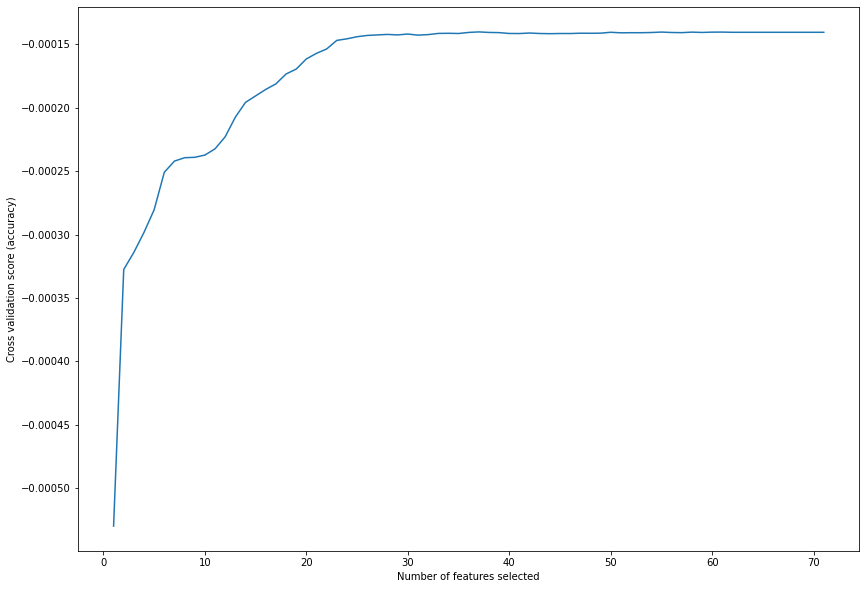

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(1, len(selector.grid_scores_) + 1),
    selector.grid_scores_,
)
plt.show()

# LGBM

## Feature importance

In [19]:
import LightGBM as lg

#LightGBM (Gradient Booster)
data = train_merged.drop(columns=["street","address"])
df = data.copy()
Y = df["price"]
X = df.drop(columns="price")

zero_features, feature_importances = lg.identify_zero_importance_features(X, Y, iterations=2)
print('zero_features:', zero_features)
print(feature_importances)

[1]	valid_0's l2: 5.18664e+13
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 4.44761e+13
[3]	valid_0's l2: 3.85455e+13
[4]	valid_0's l2: 3.36395e+13
[5]	valid_0's l2: 2.95552e+13
[6]	valid_0's l2: 2.61734e+13
[7]	valid_0's l2: 2.32531e+13
[8]	valid_0's l2: 2.08113e+13
[9]	valid_0's l2: 1.89039e+13
[10]	valid_0's l2: 1.72438e+13
[11]	valid_0's l2: 1.58288e+13
[12]	valid_0's l2: 1.46394e+13
[13]	valid_0's l2: 1.35075e+13
[14]	valid_0's l2: 1.26272e+13
[15]	valid_0's l2: 1.19027e+13
[16]	valid_0's l2: 1.12222e+13
[17]	valid_0's l2: 1.05946e+13
[18]	valid_0's l2: 1.01044e+13
[19]	valid_0's l2: 9.74683e+12
[20]	valid_0's l2: 9.45971e+12
[21]	valid_0's l2: 9.14291e+12
[22]	valid_0's l2: 8.90141e+12
[23]	valid_0's l2: 8.65574e+12
[24]	valid_0's l2: 8.39722e+12
[25]	valid_0's l2: 8.28032e+12
[26]	valid_0's l2: 8.10001e+12
[27]	valid_0's l2: 7.92538e+12
[28]	valid_0's l2: 7.74339e+12
[29]	valid_0's l2: 7.63709e+12
[30]	valid_0's l2: 7.48751e+12
[31]	valid_0's l2

# Example full run of meta model (more model interpretation in the end)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 10)
import seaborn as sns

from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost
from sklearn.model_selection import  GridSearchCV, GroupKFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error

In [14]:
train_apt = pd.read_csv("data/apartments_train.csv")
test_apt = pd.read_csv("data/apartments_test.csv")
train_buil = pd.read_csv("data/buildings_train.csv")
test_buil = pd.read_csv("data/buildings_test.csv")

train_merged = pd.merge(train_apt, train_buil.set_index('id'), how="left", left_on='building_id', right_index=True)
test_merged = pd.merge(test_apt, test_buil.set_index('id'), how="left", left_on='building_id', right_index=True)

find_closest_district(train_merged)
find_closest_district(test_merged)

 (55.560891, 37.473761)
 (55.560891, 37.473761)
 (55.921627, 37.781578)
 (55.583551, 37.711356)
 (55.921627, 37.781578)
 (55.932127, 37.793705)


In [15]:
metro = True
uni = True

if metro:
    train_merged = metro_dist(train_merged)
    test_merged = metro_dist(test_merged)

if uni:
    train_merged = university_dist(train_merged)
    test_merged = university_dist(test_merged)

In [16]:
train_merged.drop("uni", axis=1, inplace=True)
test_merged.drop("uni", axis=1, inplace=True)

In [17]:
train_merged.drop(train_merged.nlargest(5,columns="price").index,inplace=True)

In [19]:
train_merged.columns

Index(['id', 'seller', 'price', 'area_total', 'area_kitchen', 'area_living',
       'floor', 'rooms', 'layout', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'condition', 'phones', 'building_id', 'new', 'latitude',
       'longitude', 'district', 'street', 'address', 'constructed', 'material',
       'stories', 'elevator_without', 'elevator_passenger', 'elevator_service',
       'parking', 'garbage_chute', 'heating', 'dist_metro', 'dist_uni',
       'dist_from_center'],
      dtype='object')

In [20]:
# Distance from center
train_merged.loc[:,"dist_from_center"] = haversine([train_merged.latitude.values, train_merged.longitude.values], unit="km")
test_merged.loc[:,"dist_from_center"] = haversine([test_merged.latitude.values, test_merged.longitude.values],unit="km")

# Setting values further than outer point of Moscow to mean (made the result worse??)
maxDistTreshold = haversine([55.179482, 36.992857], unit="km")
print(maxDistTreshold)
train_merged.loc[train_merged.dist_from_center > 75,"dist_from_center"] = np.mean(train_merged["dist_from_center"])
test_merged.loc[test_merged.dist_from_center > 75,"dist_from_center"] = np.mean(test_merged["dist_from_center"])

75.14729191883387


In [21]:
train_merged = middle(train_merged)
test_merged = middle(test_merged)

In [22]:
test_merged_ids = test_merged.id

In [23]:
# Data Cleaning
clean_feature_ceiling(train_merged,test_merged)

train_merged, test_merged = clean_feature_constructed(train_merged,test_merged)

clean_feature_new(train_merged) 
clean_feature_new(test_merged)  

train_merged, test_merged = clean_areas(train_merged, test_merged)

train_merged, test_merged = feature_clean_average_both(train_merged, test_merged)


## create features 


In [24]:

# areaPerRoom
train_merged["areaPerRoom"] = train_merged.area_living.divide(train_merged.rooms)
test_merged["areaPerRoom"] = test_merged.area_living.divide(test_merged.rooms)

# area/ avstand til røde plass
train_merged["area_by_dist"] = train_merged.area_living.divide(train_merged.dist_from_center)
test_merged["area_by_dist"] = test_merged.area_living.divide(test_merged.dist_from_center)

# area * etasje / avstand
train_merged["area_and_floor_by_dist"] = train_merged.area_living.multiply(train_merged.floor).divide(train_merged.dist_from_center)
test_merged["area_and_floor_by_dist"] = test_merged.area_living.multiply(test_merged.floor).divide(test_merged.dist_from_center)

# floor / etasje
train_merged["relative_floor"] = train_merged.floor.divide(train_merged.stories)
test_merged["relative_floor"] = test_merged.floor.divide(test_merged.stories)

In [25]:
train_merged = high_appartment(train_merged)
test_merged = high_appartment(test_merged)

ohe_cols = ["seller", "material", "condition", "layout", "heating", "parking", "district"]

train_merged = create_dummies(train_merged, ohe_cols)
test_merged = create_dummies(test_merged, ohe_cols)

In [26]:
TRAIN_TEST_SPLIT_PERC = 0.75
uniques = train_merged["building_id"].unique()
sep = int(len(uniques) * TRAIN_TEST_SPLIT_PERC)
train_merged = train_merged.sample(frac=1).reset_index(drop=True) #For shuffling your data
train_ids, test_ids = uniques[:sep], uniques[sep:]
train, test = train_merged[train_merged.building_id.isin(train_ids)], train_merged[train_merged.building_id.isin(test_ids)]
testids = test.building_id.unique()
trainids = train.building_id.unique()
print("Intersecting ids\t", len(np.intersect1d(testids,trainids)))
print("Test \t\t\t", len(test))
print("Train \t\t\t", len(train))
print("Test Fraction:\t\t", round(len(test) / (len(train) + len(test)),3))

Intersecting ids	 0
Test 			 2519
Train 			 20761
Test Fraction:		 0.108


In [27]:
groups = train.building_id.to_numpy()

In [28]:
droppers = ["id", "street", "address", "phones", "building_id", "area_living", "area_kitchen"]
#droppers = ["id","street","address", "phones", "building_id", 'bathrooms_shared', 'bathrooms_private','windows_court', 'windows_street',
# 'stories', 'elevator_passenger', 'elevator_service', "latitude","longitude","area_living", "area_kitchen"]

In [32]:
def evaluate(model, X_train, X_test, y_train, y_test, log2=False) -> None:
    
    y_hat_test = model.predict(X_test)
    y_hat_test[y_hat_test < 0] = y_train.median()
    if log2:
        y_hat_test = 2 ** y_hat_test
    test_score = Tools.root_mean_squared_log_error(y_hat_test, y_test)
    
    y_hat_train = model.predict(X_train)
    y_hat_train[y_hat_train < 0] = y_train.median()
    if log2:
        y_hat_train = 2 ** y_hat_train
    train_score = Tools.root_mean_squared_log_error(y_hat_train,y_train)
    print(f"Train_score: {train_score}, Test_score: {test_score}")

## Catboost

### with log

In [33]:
train_log = train.copy()
train_log.price = np.log2(train_log.price)

In [34]:
cat = CatBoostRegressor(
    depth=9,
    iterations=2000,
    learning_rate=0.05,
)
cat.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)
evaluate(cat, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

0:	learn: 1.2133848	total: 30.4ms	remaining: 1m
1:	learn: 1.1638866	total: 44.9ms	remaining: 44.8s
2:	learn: 1.1182921	total: 58.9ms	remaining: 39.2s
3:	learn: 1.0736202	total: 72.1ms	remaining: 36s
4:	learn: 1.0320966	total: 88.1ms	remaining: 35.1s
5:	learn: 0.9917136	total: 106ms	remaining: 35.1s
6:	learn: 0.9544859	total: 119ms	remaining: 34s
7:	learn: 0.9181431	total: 131ms	remaining: 32.7s
8:	learn: 0.8842327	total: 143ms	remaining: 31.6s
9:	learn: 0.8515064	total: 155ms	remaining: 30.8s
10:	learn: 0.8204667	total: 167ms	remaining: 30.2s
11:	learn: 0.7901816	total: 182ms	remaining: 30.1s
12:	learn: 0.7629838	total: 208ms	remaining: 31.8s
13:	learn: 0.7363027	total: 219ms	remaining: 31.1s
14:	learn: 0.7125124	total: 231ms	remaining: 30.5s
15:	learn: 0.6895637	total: 243ms	remaining: 30.2s
16:	learn: 0.6679898	total: 256ms	remaining: 29.9s
17:	learn: 0.6479290	total: 271ms	remaining: 29.9s
18:	learn: 0.6283841	total: 285ms	remaining: 29.7s
19:	learn: 0.6093944	total: 299ms	remaining

In [35]:
# cat.grid_search_group(train_log.drop(droppers, axis=1), groups)
# cat.evaluate(train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

## XGBOOST

## with log

In [36]:
train_log = train.copy()
train_log.price = np.log2(train_log.price)

In [37]:
xgb = XGBRegressor(
    random_state=47, 
    n_estimators=1000, 
    learning_rate = 0.05, 
    subsample=1, 
    verbosity=1,
    max_depth=9,
)
xgb.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)
evaluate(xgb, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

Train_score: 0.02555224862508672, Test_score: 0.16974944796750624


In [38]:
# xgb_mod.grid_search_group(train_log.drop(droppers,axis=1), groups)
# xgb_mod.evaluate(train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

In [39]:
xgb_big = XGBRegressor(seed=47, n_estimators=5000, learning_rate = 0.01, subsample=0.7, verbosity=1, alpha=0.11)
xgb_big.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)

evaluate(xgb_big, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

Train_score: 0.06216746740488478, Test_score: 0.16302992833428875


## LGBM

## with log

In [40]:
train_log = train.copy()
train_log.price = np.log2(train_log.price)

lgbm = LGBMRegressor(
    random_state=10,
    n_estimators=1000,
    max_depth=14,
    num_leaves=50,
    min_data_in_leaf=75,
)
lgbm.fit(train_log.drop(droppers + ["price"],axis=1), train_log.price)

evaluate(lgbm, train_log.drop(droppers + ["price"], axis=1), test.drop(droppers + ["price"], axis=1), train.price, test.price, log2=True) 

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
Train_score: 0.05278550944782065, Test_score: 0.17300694998960078


## Stack the models

In [41]:
def evaluate(pred, y_test) -> None:
    return Tools.root_mean_squared_log_error(pred, y_test)

In [42]:
# 2 ** before average
cat_pred = 2 ** cat.predict(test.drop(droppers + ["price"],axis=1))
xg_pred = 2 ** xgb.predict(test.drop(droppers + ["price"], axis=1))
lgbm_pred = 2 ** lgbm.predict(test.drop(droppers + ["price"],axis=1))
xg_big_pred = 2 ** xgb_big.predict(test.drop(droppers+["price"],axis=1))
##rf_pred = 2 ** rf.predict(test.drop(droppers+["price"],axis=1))


AVG_pred = (cat_pred + xg_pred + lgbm_pred + xg_big_pred) / 4
#AVG5_pred = (cat_pred + xg_pred + lgbm_pred + xg_big_pred + rf_pred) / 5

best_model_wheighted = (cat_pred * 0.2) + (xg_pred * 0.2) + (xg_big_pred * 0.5) + (lgbm_pred * 0.1)
best_kaggle = (cat_pred * 0.3) + (xg_pred * 0.1) + xg_big_pred * 0.5 + (lgbm_pred * 0.1)

#withrf = (cat_pred * 0.2) + (xg_pred * 0.1) + (xg_big_pred * 0.5) + (lgbm_pred * 0.15) + (rf_pred *0.05)
#xgb_wheighted = (cat_pred * 0.19) + (xg_pred * 0.3) + (xg_big_pred * 0.45) + rf_pred * 0.01 + lgbm_pred*0.05




print("AVG 4: \t\t", evaluate(AVG_pred, test.price))
#print("AVG 5: \t\t", evaluate(AVG5_pred, test.price))
print("big_weighted: \t",evaluate(best_model_wheighted, test.price))
print("best_kaggle: \t",evaluate(best_kaggle, test.price))
#print("with rf: \t",evaluate(withrf, test.price))
#print(evaluate(xgb_wheighted, test.price))

AVG 4: 		 0.16211253209642282
big_weighted: 	 0.16166413139655533
best_kaggle: 	 0.16138693147037303


## select model(s) to refit

In [43]:
full_log = train_merged.copy()
full_log.price = np.log2(full_log.price)

# xgb_mod.refit(full_log.drop(droppers, axis=1))
# cat.refit(full_log.drop(droppers, axis=1))
# lgbm.refit(full_log.drop(droppers, axis=1))

In [44]:
lgbm.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)
xgb.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)
xgb_big.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)
cat.fit(full_log.drop(droppers + ["price"], axis=1), full_log.price)

[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
0:	learn: 1.1920991	total: 12.2ms	remaining: 24.4s
1:	learn: 1.1436872	total: 24.6ms	remaining: 24.6s
2:	learn: 1.0988560	total: 36.8ms	remaining: 24.5s
3:	learn: 1.0554054	total: 49.7ms	remaining: 24.8s
4:	learn: 1.0144818	total: 61.6ms	remaining: 24.6s
5:	learn: 0.9746836	total: 73ms	remaining: 24.3s
6:	learn: 0.9374867	total: 84.8ms	remaining: 24.1s
7:	learn: 0.9015636	total: 95.8ms	remaining: 23.8s
8:	learn: 0.8678281	total: 107ms	remaining: 23.6s
9:	learn: 0.8366658	total: 118ms	remaining: 23.4s
10:	learn: 0.8067881	total: 138ms	remaining: 25s
11:	learn: 0.7785619	total: 149ms	remaining: 24.7s
12:	learn: 0.7521814	total: 160ms	remaining: 24.4s
13:	learn: 0.7259291	total: 171ms	remaining: 24.2s
14:	learn: 0.7017619	total: 182ms	remaining: 24.1s
15:	learn: 0.6787948	total: 193ms	remaining: 23.9s
16:	learn: 0.6571007	total: 204ms	remaining: 23.8s
17:	learn: 0.6365

## Kaggle prediction

In [45]:
# Fit model to the full dataset
#X_train, y_train = data.drop(["id","layout","price","building_id","address","street"],axis=1), data.price
X_test = test_merged.drop(droppers, axis=1)

# make predictions
cat_pred = 2 ** cat.predict(X_test)
xg_pred = 2 ** xgb.predict(X_test)
lgbm_pred = 2 ** lgbm.predict(X_test)
xg_big_pred = 2 ** xgb_big.predict(X_test)
# rf_pred = 2 ** rf.predict(X_test)
best_model_wheighted = (cat_pred * 0.5) + (xg_pred * 0.2) + (xg_big_pred * 0.2) + (lgbm_pred * 0.1)
#best_model_wheighted = (cat_pred * 0.19) + (xg_pred * 0.3) + (xg_big_pred * 0.45) + rf_pred * 0.01 + lgbm_pred*0.05

# Construct submission dataframe
submission = pd.DataFrame()
submission['id'] = test_merged_ids
submission['price_prediction'] = best_model_wheighted # Predict

In [46]:
submission['price_prediction'].fillna(train_merged.price.mean(), inplace=True) # Fill missing entries with mean predictor
submission.loc[submission.price_prediction < 0,"price_prediction"] = train_merged.price.mean()
print(f'Generated {len(submission)} predictions')
submission.sort_index(inplace=True)
#submission.price_prediction  = np.exp(submission.price_prediction)
# Export submission to csv with headers
submission.to_csv('sample_submission.csv', index=False)

Generated 9937 predictions


# Model interpretation

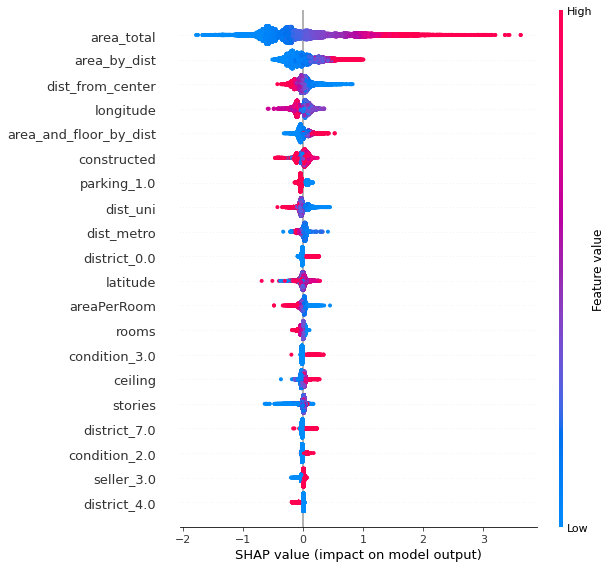

In [54]:
import shap
shap.initjs() # you need this so the plots can be displayed

explainer = shap.TreeExplainer(xgb_big)
X = train.drop(droppers + ["price"],axis=1).copy()
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [61]:
shap.force_plot(explainer.expected_value, shap_values[:100], X[:100])

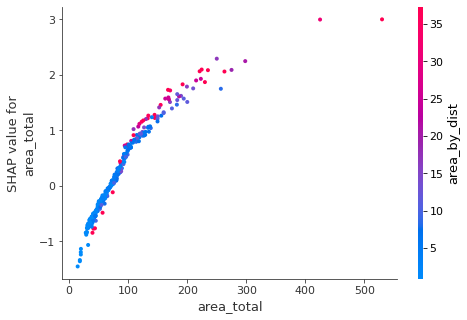

In [77]:
shap.dependence_plot("area_total", shap_values[:400], X[:400])

In [71]:
X.columns

Index(['area_total', 'floor', 'rooms', 'ceiling', 'bathrooms_shared',
       'bathrooms_private', 'windows_court', 'windows_street', 'balconies',
       'loggias', 'new', 'latitude', 'longitude', 'constructed', 'stories',
       'elevator_without', 'elevator_passenger', 'elevator_service',
       'garbage_chute', 'dist_metro', 'dist_uni', 'dist_from_center', 'middle',
       'areaPerRoom', 'area_by_dist', 'area_and_floor_by_dist',
       'relative_floor', 'high', 'seller_0.0', 'seller_1.0', 'seller_2.0',
       'seller_3.0', 'seller_nan', 'material_0.0', 'material_1.0',
       'material_2.0', 'material_3.0', 'material_4.0', 'material_5.0',
       'material_6.0', 'material_nan', 'condition_0.0', 'condition_1.0',
       'condition_2.0', 'condition_3.0', 'condition_nan', 'layout_0.0',
       'layout_1.0', 'layout_2.0', 'layout_nan', 'heating_0.0', 'heating_1.0',
       'heating_2.0', 'heating_3.0', 'heating_nan', 'parking_0.0',
       'parking_1.0', 'parking_2.0', 'parking_nan', 'district

From the plots, we figured out what had the most impact on the model and what had less, We tried to remove some of the less valuable but got lower scores.